**генеративно-состязательные модели (GAN)** 

Евгений Борисов esborisov@sevsu.ru

---

Generative Adversarial Nets  
Ian J. Goodfellow, Yoshua Bengio ....  
2014  

https://arxiv.org/pdf/1406.2661.pdf

Generative adversarial networks  
Max Strakhov 
2018

https://habr.com/ru/post/352794/

Gulli Antonio, Pal Sujit. Deep Learning with Keras -- Packt Publishing, 2017

пара нейросетей генератор (создаёт "подделку") и дискриминатор (распознаёт подделку)

одна эпоха обучения состоит из следующих шагов

1. генератор создаёт пакет "подделок" из случайного шума

2. дискриминатор имеет пакет "настоящих" образцов 
   и обучается распознавать фальшивки на наборе фальшивые/настоящие

3. собираем конвейер генератор-дискриминатор
   фиксируем веса дискриминатора (т.е. дискриминатор в конвейере не обучаем)
   и обучаем генератор "обманывать" дискриминатор

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.datasets import mnist

from tensorflow.keras import backend as K

from tensorflow.keras.utils import plot_model

In [4]:
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.__version__, tf.keras.__version__

('2.3.1', '2.4.0')

---

In [5]:
# # import random
# import numpy as np

# import matplotlib.pyplot as plt
# from matplotlib import cm

In [3]:
# # default GPU device
# if tf.test.is_built_with_cuda():
#     print([ 
#           d.physical_device_desc 
#           for d in tf.python.client.device_lib.list_local_devices() 
#           if d.device_type == 'GPU' and d.name==tf.test.gpu_device_name()
#         ])

---

In [6]:
# !rm -r result_old
# !mv result result_old
!mkdir result

---

In [7]:
(X_train, _),(_, _) = mnist.load_data()

X_train.shape

(60000, 28, 28)

In [8]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
img_rows, img_cols

(28, 28)

In [9]:
X_train = (X_train - 127.5) / 127.5

In [10]:
# X_train = X_train[:,np.newaxis,:,:].astype('float32')
X_train = X_train[:,:,:,np.newaxis].astype('float32')
X_train.shape

(60000, 28, 28, 1)

---

In [11]:
generator = Sequential(name='generator')
generator.add(Dense(1024, input_shape=(100, ), activation='tanh'))
generator.add(Dense(128 * 7 * 7))
generator.add(BatchNormalization())
generator.add(Activation('tanh'))
generator.add(Reshape((7, 7, 128), input_shape=(7 * 7 * 128,)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64,(5,5),padding='same',activation='tanh',data_format='channels_last'))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1,(5,5),padding='same',activation='tanh',data_format='channels_last'))

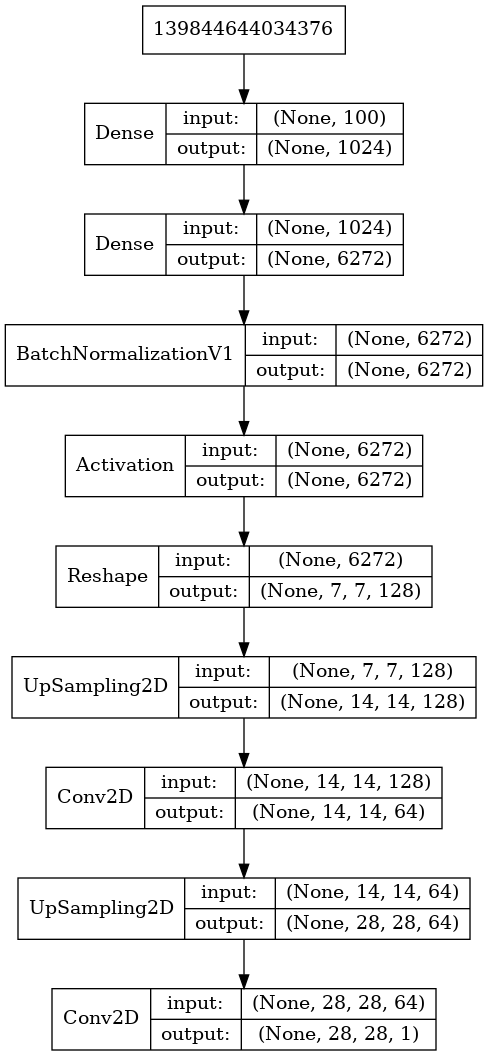

In [12]:
plot_model(generator,to_file='result/model-generator.png', show_layer_names=False, show_shapes=True )
# IPython.display.Image('result/model-generator.png')

----

In [13]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5),
                padding='same',
                input_shape=(28, 28, 1),
                activation='tanh',
                data_format='channels_last'
   ))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Conv2D(128,(5,5),activation='tanh',data_format='channels_last'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dense(1024, activation='tanh'))
discriminator.add(Dense(1, activation='sigmoid'))

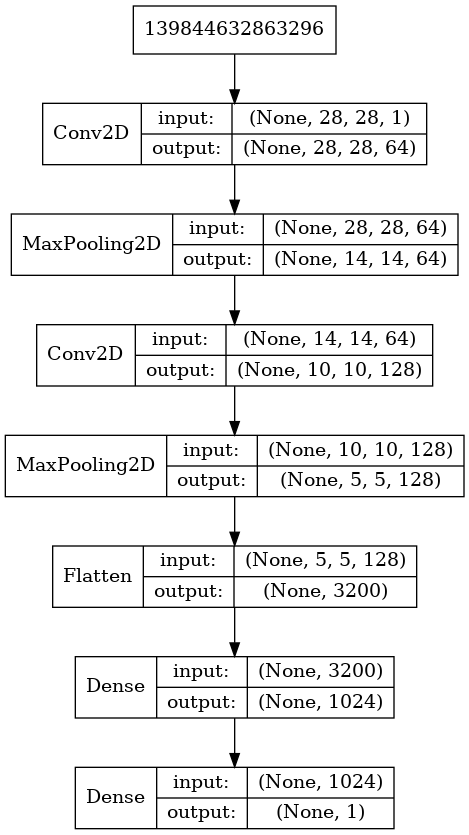

In [14]:
plot_model(discriminator,to_file='result/model-discriminator.png',show_layer_names=False, show_shapes=True )
# IPython.display.Image('result/model-discriminator.png')

---

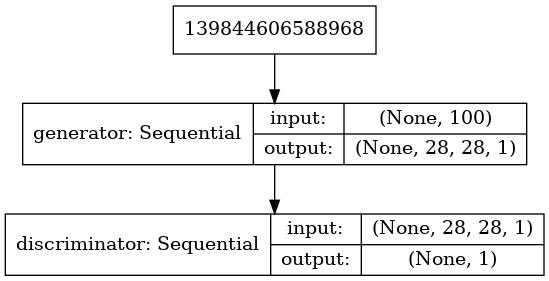

In [15]:
discriminator_on_generator = Sequential()
discriminator_on_generator.add(generator)
discriminator.trainable = False
discriminator_on_generator.add(discriminator)

plot_model( discriminator_on_generator, 
            to_file='result/model-discriminator_on_generator.png', 
            show_shapes=True, 
            show_layer_names=True )

# IPython.display.Image('result/model-discriminator_on_generator.png')

---

In [16]:
generator.compile(loss='binary_crossentropy', optimizer="SGD")

discriminator_on_generator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True)
  )

discriminator.trainable = True
discriminator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True)
  )


---

In [17]:
from PIL import Image

def save_images(X,e,b,mc=10):
    # mc = 14 # количество картинок в одной строке 
    n,r,c,m = X.shape # примеры, высота, ширина, каналы
    mr = int(np.ceil(n/mc)) # количество строк 
    
    # print(n,c,r,m)
    
    im = []
    for k in range(m):
        xk = X[:,:,:,k] # канал k
        # дополняем строку до полного размера пустыми картинками
        xk = np.vstack([xk,-np.ones([(mc*mr-n),r,c])]) 
        # укладываем картинки, [mr x mc] картинок размера [r x c]
        xk = xk.reshape(mr,mc,r,c).swapaxes(1,2).reshape(mr*r,mc*c) 
        im.append(xk*127.5+127.5) # масштабируем в [0,255]

    im = np.stack(im,axis=2) if m>1 else im[0]
   
    Image.fromarray(im.astype(np.uint8)).save('result/%02d_%d.png'%(e,b) )


In [18]:
# xx = np.random.rand(128,100,3)*255.
# Image.fromarray(xx.astype(np.uint8)).save('result/test.png')

---

In [19]:
BATCH_SIZE = 250
N_EPOCH = 50

N_EX = X_train.shape[0]
N_BATCH = int( np.floor(N_EX/BATCH_SIZE) )

mc=int(np.ceil(np.sqrt(BATCH_SIZE))) 

N_EX, N_BATCH

(60000, 240)

In [20]:
def chunks(X, batch_size=BATCH_SIZE): 
    for i in range(0, len(X), batch_size): 
        yield X[i:i+batch_size]

In [21]:
%%time

for e in range(N_EPOCH):
    print('epoch: ', e+1,'/',N_EPOCH)
    
    for b,Xb in enumerate(chunks(X_train)):
        print('\tbatch %d/%d, loss '%(b+1,N_BATCH))

        # генератор создаёт пакет "подделок" из случайного шума
        noise = np.random.uniform(-1, 1, (BATCH_SIZE,100))
        Xg = generator.predict(noise, verbose=0)
        
        # рисуем результат после каждого 200-го батча
        if b % 200 == 0: save_images(Xg,e,b,mc=mc)
        
        # собираем учебный набор для дискриминатора
        # из "фальшивых" и "настоящик" картинок
        X = np.concatenate((Xb, Xg))
        y = [1] * Xb.shape[0] + [0] * Xg.shape[0]

        # обучаем дискриминатор выявлять "фальшивые"
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y)
        print('\t\t%f : discriminator'%(d_loss))
        
        # обучаем генератор "обманывать" дискриминатор
        noise = np.random.uniform(-1,1,(BATCH_SIZE,100))
        discriminator.trainable = False
        g_loss = discriminator_on_generator.train_on_batch( noise, [1]*BATCH_SIZE)
        
        print('\t\t%f : generator'%(g_loss))


epoch:  1 / 50
	batch 1/240, loss 
		0.621710 : discriminator
		0.613983 : generator
	batch 2/240, loss 
		0.613939 : discriminator
		0.608319 : generator
	batch 3/240, loss 
		0.605268 : discriminator
		0.605608 : generator
	batch 4/240, loss 
		0.596694 : discriminator
		0.605063 : generator
	batch 5/240, loss 
		0.589088 : discriminator
		0.597091 : generator
	batch 6/240, loss 
		0.581400 : discriminator
		0.590472 : generator
	batch 7/240, loss 
		0.569191 : discriminator
		0.585879 : generator
	batch 8/240, loss 
		0.559644 : discriminator
		0.585062 : generator
	batch 9/240, loss 
		0.548308 : discriminator
		0.578181 : generator
	batch 10/240, loss 
		0.533685 : discriminator
		0.576192 : generator
	batch 11/240, loss 
		0.526121 : discriminator
		0.570637 : generator
	batch 12/240, loss 
		0.516804 : discriminator
		0.563785 : generator
	batch 13/240, loss 
		0.500420 : discriminator
		0.561642 : generator
	batch 14/240, loss 
		0.496060 : discriminator
		0.562305 : generator


		0.912403 : generator
	batch 117/240, loss 
		0.253847 : discriminator
		0.882889 : generator
	batch 118/240, loss 
		0.218533 : discriminator
		0.878466 : generator
	batch 119/240, loss 
		0.237602 : discriminator
		0.859644 : generator
	batch 120/240, loss 
		0.262851 : discriminator
		0.850239 : generator
	batch 121/240, loss 
		0.253821 : discriminator
		0.846063 : generator
	batch 122/240, loss 
		0.235241 : discriminator
		0.839050 : generator
	batch 123/240, loss 
		0.265665 : discriminator
		0.827180 : generator
	batch 124/240, loss 
		0.238660 : discriminator
		0.811487 : generator
	batch 125/240, loss 
		0.267509 : discriminator
		0.822610 : generator
	batch 126/240, loss 
		0.256221 : discriminator
		0.811496 : generator
	batch 127/240, loss 
		0.276489 : discriminator
		0.781665 : generator
	batch 128/240, loss 
		0.262575 : discriminator
		0.787168 : generator
	batch 129/240, loss 
		0.239263 : discriminator
		0.780255 : generator
	batch 130/240, loss 
		0.235808 : discri

		0.294623 : discriminator
		1.070440 : generator
	batch 232/240, loss 
		0.369208 : discriminator
		1.067049 : generator
	batch 233/240, loss 
		0.331078 : discriminator
		1.006053 : generator
	batch 234/240, loss 
		0.243913 : discriminator
		0.980178 : generator
	batch 235/240, loss 
		0.327349 : discriminator
		1.021026 : generator
	batch 236/240, loss 
		0.319150 : discriminator
		0.977621 : generator
	batch 237/240, loss 
		0.274993 : discriminator
		0.983828 : generator
	batch 238/240, loss 
		0.197864 : discriminator
		1.052484 : generator
	batch 239/240, loss 
		0.293680 : discriminator
		1.074813 : generator
	batch 240/240, loss 
		0.300432 : discriminator
		1.068074 : generator
epoch:  2 / 50
	batch 1/240, loss 
		0.338862 : discriminator
		1.054790 : generator
	batch 2/240, loss 
		0.354332 : discriminator
		1.115497 : generator
	batch 3/240, loss 
		0.353129 : discriminator
		1.056184 : generator
	batch 4/240, loss 
		0.352572 : discriminator
		1.013003 : generator
	batch 

		0.459709 : discriminator
		1.003395 : generator
	batch 109/240, loss 
		0.462135 : discriminator
		1.017140 : generator
	batch 110/240, loss 
		0.512446 : discriminator
		1.027517 : generator
	batch 111/240, loss 
		0.475657 : discriminator
		0.979125 : generator
	batch 112/240, loss 
		0.479161 : discriminator
		0.999918 : generator
	batch 113/240, loss 
		0.467677 : discriminator
		1.013088 : generator
	batch 114/240, loss 
		0.483925 : discriminator
		1.033016 : generator
	batch 115/240, loss 
		0.486865 : discriminator
		1.031844 : generator
	batch 116/240, loss 
		0.487102 : discriminator
		0.992867 : generator
	batch 117/240, loss 
		0.469956 : discriminator
		0.991865 : generator
	batch 118/240, loss 
		0.464195 : discriminator
		1.022227 : generator
	batch 119/240, loss 
		0.467962 : discriminator
		0.999810 : generator
	batch 120/240, loss 
		0.507275 : discriminator
		0.999937 : generator
	batch 121/240, loss 
		0.518900 : discriminator
		0.965346 : generator
	batch 122/240

		1.062931 : generator
	batch 223/240, loss 
		0.574898 : discriminator
		1.086679 : generator
	batch 224/240, loss 
		0.477507 : discriminator
		1.099615 : generator
	batch 225/240, loss 
		0.525887 : discriminator
		1.140925 : generator
	batch 226/240, loss 
		0.498927 : discriminator
		1.055024 : generator
	batch 227/240, loss 
		0.574192 : discriminator
		1.006472 : generator
	batch 228/240, loss 
		0.527111 : discriminator
		1.011788 : generator
	batch 229/240, loss 
		0.489244 : discriminator
		0.995428 : generator
	batch 230/240, loss 
		0.521121 : discriminator
		1.066468 : generator
	batch 231/240, loss 
		0.488948 : discriminator
		1.074913 : generator
	batch 232/240, loss 
		0.507209 : discriminator
		1.054735 : generator
	batch 233/240, loss 
		0.501896 : discriminator
		1.048455 : generator
	batch 234/240, loss 
		0.496705 : discriminator
		1.070829 : generator
	batch 235/240, loss 
		0.460889 : discriminator
		1.113474 : generator
	batch 236/240, loss 
		0.490735 : discri

		1.127433 : generator
	batch 100/240, loss 
		0.477627 : discriminator
		1.183649 : generator
	batch 101/240, loss 
		0.474813 : discriminator
		1.127564 : generator
	batch 102/240, loss 
		0.485175 : discriminator
		1.164100 : generator
	batch 103/240, loss 
		0.471229 : discriminator
		1.205015 : generator
	batch 104/240, loss 
		0.493138 : discriminator
		1.116186 : generator
	batch 105/240, loss 
		0.467660 : discriminator
		1.134774 : generator
	batch 106/240, loss 
		0.489460 : discriminator
		1.115717 : generator
	batch 107/240, loss 
		0.506186 : discriminator
		1.061698 : generator
	batch 108/240, loss 
		0.447130 : discriminator
		1.144349 : generator
	batch 109/240, loss 
		0.489961 : discriminator
		1.172559 : generator
	batch 110/240, loss 
		0.530562 : discriminator
		1.105659 : generator
	batch 111/240, loss 
		0.498783 : discriminator
		1.093765 : generator
	batch 112/240, loss 
		0.483201 : discriminator
		1.119335 : generator
	batch 113/240, loss 
		0.475782 : discri

		1.201624 : generator
	batch 215/240, loss 
		0.446856 : discriminator
		1.130511 : generator
	batch 216/240, loss 
		0.442485 : discriminator
		1.100021 : generator
	batch 217/240, loss 
		0.435800 : discriminator
		1.126122 : generator
	batch 218/240, loss 
		0.437434 : discriminator
		1.153214 : generator
	batch 219/240, loss 
		0.414873 : discriminator
		1.218991 : generator
	batch 220/240, loss 
		0.478268 : discriminator
		1.147577 : generator
	batch 221/240, loss 
		0.437048 : discriminator
		1.155735 : generator
	batch 222/240, loss 
		0.417018 : discriminator
		1.143981 : generator
	batch 223/240, loss 
		0.456357 : discriminator
		1.172076 : generator
	batch 224/240, loss 
		0.411509 : discriminator
		1.153494 : generator
	batch 225/240, loss 
		0.465160 : discriminator
		1.186504 : generator
	batch 226/240, loss 
		0.444282 : discriminator
		1.161135 : generator
	batch 227/240, loss 
		0.485757 : discriminator
		1.056294 : generator
	batch 228/240, loss 
		0.460658 : discri

		1.136369 : generator
	batch 90/240, loss 
		0.394011 : discriminator
		1.152468 : generator
	batch 91/240, loss 
		0.523288 : discriminator
		1.112989 : generator
	batch 92/240, loss 
		0.468891 : discriminator
		1.075698 : generator
	batch 93/240, loss 
		0.453497 : discriminator
		1.151004 : generator
	batch 94/240, loss 
		0.453977 : discriminator
		1.200002 : generator
	batch 95/240, loss 
		0.411845 : discriminator
		1.183882 : generator
	batch 96/240, loss 
		0.427150 : discriminator
		1.167061 : generator
	batch 97/240, loss 
		0.425782 : discriminator
		1.156941 : generator
	batch 98/240, loss 
		0.428838 : discriminator
		1.192495 : generator
	batch 99/240, loss 
		0.453549 : discriminator
		1.176730 : generator
	batch 100/240, loss 
		0.422733 : discriminator
		1.197326 : generator
	batch 101/240, loss 
		0.401301 : discriminator
		1.222700 : generator
	batch 102/240, loss 
		0.454483 : discriminator
		1.264023 : generator
	batch 103/240, loss 
		0.409485 : discriminator
		

		1.366486 : generator
	batch 205/240, loss 
		0.394873 : discriminator
		1.407270 : generator
	batch 206/240, loss 
		0.392922 : discriminator
		1.310907 : generator
	batch 207/240, loss 
		0.385310 : discriminator
		1.255846 : generator
	batch 208/240, loss 
		0.348323 : discriminator
		1.270922 : generator
	batch 209/240, loss 
		0.426735 : discriminator
		1.147448 : generator
	batch 210/240, loss 
		0.372502 : discriminator
		1.274276 : generator
	batch 211/240, loss 
		0.360149 : discriminator
		1.384744 : generator
	batch 212/240, loss 
		0.358983 : discriminator
		1.366324 : generator
	batch 213/240, loss 
		0.358735 : discriminator
		1.395445 : generator
	batch 214/240, loss 
		0.376430 : discriminator
		1.366425 : generator
	batch 215/240, loss 
		0.371697 : discriminator
		1.320691 : generator
	batch 216/240, loss 
		0.354292 : discriminator
		1.319341 : generator
	batch 217/240, loss 
		0.350988 : discriminator
		1.324051 : generator
	batch 218/240, loss 
		0.378891 : discri

		1.367393 : generator
	batch 80/240, loss 
		0.390931 : discriminator
		1.313458 : generator
	batch 81/240, loss 
		0.382255 : discriminator
		1.263337 : generator
	batch 82/240, loss 
		0.373852 : discriminator
		1.471606 : generator
	batch 83/240, loss 
		0.346007 : discriminator
		1.401310 : generator
	batch 84/240, loss 
		0.381241 : discriminator
		1.331327 : generator
	batch 85/240, loss 
		0.342419 : discriminator
		1.402471 : generator
	batch 86/240, loss 
		0.360218 : discriminator
		1.365170 : generator
	batch 87/240, loss 
		0.322050 : discriminator
		1.403190 : generator
	batch 88/240, loss 
		0.393341 : discriminator
		1.419142 : generator
	batch 89/240, loss 
		0.370284 : discriminator
		1.249628 : generator
	batch 90/240, loss 
		0.349369 : discriminator
		1.416669 : generator
	batch 91/240, loss 
		0.464306 : discriminator
		1.225718 : generator
	batch 92/240, loss 
		0.403904 : discriminator
		1.279305 : generator
	batch 93/240, loss 
		0.396315 : discriminator
		1.35

		0.475502 : discriminator
		1.215197 : generator
	batch 195/240, loss 
		0.407005 : discriminator
		1.344735 : generator
	batch 196/240, loss 
		0.416844 : discriminator
		1.162630 : generator
	batch 197/240, loss 
		0.460126 : discriminator
		1.062976 : generator
	batch 198/240, loss 
		0.417205 : discriminator
		1.558182 : generator
	batch 199/240, loss 
		0.411563 : discriminator
		1.277276 : generator
	batch 200/240, loss 
		0.427344 : discriminator
		1.140032 : generator
	batch 201/240, loss 
		0.391911 : discriminator
		1.395333 : generator
	batch 202/240, loss 
		0.434158 : discriminator
		1.154656 : generator
	batch 203/240, loss 
		0.409561 : discriminator
		1.380093 : generator
	batch 204/240, loss 
		0.392136 : discriminator
		1.425273 : generator
	batch 205/240, loss 
		0.396888 : discriminator
		1.358146 : generator
	batch 206/240, loss 
		0.413428 : discriminator
		1.146785 : generator
	batch 207/240, loss 
		0.405841 : discriminator
		1.342248 : generator
	batch 208/240

		0.468257 : discriminator
		1.002528 : generator
	batch 72/240, loss 
		0.457312 : discriminator
		1.402699 : generator
	batch 73/240, loss 
		0.468576 : discriminator
		1.185128 : generator
	batch 74/240, loss 
		0.455040 : discriminator
		1.142712 : generator
	batch 75/240, loss 
		0.403879 : discriminator
		1.483454 : generator
	batch 76/240, loss 
		0.437756 : discriminator
		1.048842 : generator
	batch 77/240, loss 
		0.465689 : discriminator
		1.350100 : generator
	batch 78/240, loss 
		0.566792 : discriminator
		1.053258 : generator
	batch 79/240, loss 
		0.549313 : discriminator
		1.227055 : generator
	batch 80/240, loss 
		0.491058 : discriminator
		1.283186 : generator
	batch 81/240, loss 
		0.468722 : discriminator
		1.146505 : generator
	batch 82/240, loss 
		0.437009 : discriminator
		1.271415 : generator
	batch 83/240, loss 
		0.455662 : discriminator
		1.185973 : generator
	batch 84/240, loss 
		0.486495 : discriminator
		1.108186 : generator
	batch 85/240, loss 
		0.41

		0.403038 : discriminator
		1.581510 : generator
	batch 187/240, loss 
		0.461499 : discriminator
		0.968270 : generator
	batch 188/240, loss 
		0.431658 : discriminator
		1.589088 : generator
	batch 189/240, loss 
		0.443657 : discriminator
		0.957225 : generator
	batch 190/240, loss 
		0.444285 : discriminator
		1.467692 : generator
	batch 191/240, loss 
		0.511394 : discriminator
		1.007169 : generator
	batch 192/240, loss 
		0.472779 : discriminator
		1.455634 : generator
	batch 193/240, loss 
		0.505488 : discriminator
		0.999473 : generator
	batch 194/240, loss 
		0.483758 : discriminator
		1.365354 : generator
	batch 195/240, loss 
		0.433201 : discriminator
		1.199084 : generator
	batch 196/240, loss 
		0.433164 : discriminator
		1.249749 : generator
	batch 197/240, loss 
		0.491861 : discriminator
		1.015984 : generator
	batch 198/240, loss 
		0.434774 : discriminator
		1.501856 : generator
	batch 199/240, loss 
		0.442263 : discriminator
		0.927966 : generator
	batch 200/240

		0.373209 : discriminator
		1.042094 : generator
	batch 62/240, loss 
		0.348327 : discriminator
		1.762336 : generator
	batch 63/240, loss 
		0.353989 : discriminator
		0.981932 : generator
	batch 64/240, loss 
		0.425722 : discriminator
		1.658380 : generator
	batch 65/240, loss 
		0.478328 : discriminator
		0.867851 : generator
	batch 66/240, loss 
		0.398097 : discriminator
		1.882065 : generator
	batch 67/240, loss 
		0.380517 : discriminator
		1.030382 : generator
	batch 68/240, loss 
		0.372509 : discriminator
		1.778573 : generator
	batch 69/240, loss 
		0.438171 : discriminator
		1.022022 : generator
	batch 70/240, loss 
		0.397820 : discriminator
		1.885436 : generator
	batch 71/240, loss 
		0.419144 : discriminator
		0.818493 : generator
	batch 72/240, loss 
		0.435758 : discriminator
		2.105635 : generator
	batch 73/240, loss 
		0.460768 : discriminator
		0.809251 : generator
	batch 74/240, loss 
		0.463626 : discriminator
		2.118681 : generator
	batch 75/240, loss 
		0.38

		0.433935 : discriminator
		2.262037 : generator
	batch 177/240, loss 
		0.383052 : discriminator
		0.967970 : generator
	batch 178/240, loss 
		0.387084 : discriminator
		2.097957 : generator
	batch 179/240, loss 
		0.337979 : discriminator
		1.066039 : generator
	batch 180/240, loss 
		0.373504 : discriminator
		1.861246 : generator
	batch 181/240, loss 
		0.367688 : discriminator
		0.997838 : generator
	batch 182/240, loss 
		0.365808 : discriminator
		2.206007 : generator
	batch 183/240, loss 
		0.394813 : discriminator
		0.889870 : generator
	batch 184/240, loss 
		0.394406 : discriminator
		2.175604 : generator
	batch 185/240, loss 
		0.396496 : discriminator
		0.812888 : generator
	batch 186/240, loss 
		0.418566 : discriminator
		2.663934 : generator
	batch 187/240, loss 
		0.492648 : discriminator
		0.776466 : generator
	batch 188/240, loss 
		0.476358 : discriminator
		2.683395 : generator
	batch 189/240, loss 
		0.478303 : discriminator
		0.675774 : generator
	batch 190/240

		0.288847 : discriminator
		1.698858 : generator
	batch 52/240, loss 
		0.354276 : discriminator
		1.269655 : generator
	batch 53/240, loss 
		0.391536 : discriminator
		1.668742 : generator
	batch 54/240, loss 
		0.293643 : discriminator
		1.830400 : generator
	batch 55/240, loss 
		0.371637 : discriminator
		1.020944 : generator
	batch 56/240, loss 
		0.339050 : discriminator
		2.430228 : generator
	batch 57/240, loss 
		0.562124 : discriminator
		0.731032 : generator
	batch 58/240, loss 
		0.486998 : discriminator
		2.576043 : generator
	batch 59/240, loss 
		0.458886 : discriminator
		0.739562 : generator
	batch 60/240, loss 
		0.434919 : discriminator
		2.527542 : generator
	batch 61/240, loss 
		0.330938 : discriminator
		1.257816 : generator
	batch 62/240, loss 
		0.290408 : discriminator
		2.140184 : generator
	batch 63/240, loss 
		0.266398 : discriminator
		1.295225 : generator
	batch 64/240, loss 
		0.316255 : discriminator
		1.796746 : generator
	batch 65/240, loss 
		0.37

		0.283171 : discriminator
		1.754889 : generator
	batch 167/240, loss 
		0.296002 : discriminator
		1.711433 : generator
	batch 168/240, loss 
		0.336553 : discriminator
		1.729478 : generator
	batch 169/240, loss 
		0.399406 : discriminator
		1.528658 : generator
	batch 170/240, loss 
		0.348100 : discriminator
		1.710443 : generator
	batch 171/240, loss 
		0.381322 : discriminator
		1.421696 : generator
	batch 172/240, loss 
		0.286040 : discriminator
		2.164986 : generator
	batch 173/240, loss 
		0.328182 : discriminator
		1.257294 : generator
	batch 174/240, loss 
		0.307316 : discriminator
		2.325639 : generator
	batch 175/240, loss 
		0.350376 : discriminator
		1.086545 : generator
	batch 176/240, loss 
		0.361583 : discriminator
		2.473747 : generator
	batch 177/240, loss 
		0.319734 : discriminator
		1.327309 : generator
	batch 178/240, loss 
		0.344883 : discriminator
		2.296847 : generator
	batch 179/240, loss 
		0.292830 : discriminator
		1.297139 : generator
	batch 180/240

		3.261462 : generator
	batch 41/240, loss 
		0.478253 : discriminator
		1.164473 : generator
	batch 42/240, loss 
		0.394137 : discriminator
		2.310844 : generator
	batch 43/240, loss 
		0.257893 : discriminator
		1.578448 : generator
	batch 44/240, loss 
		0.292819 : discriminator
		1.659429 : generator
	batch 45/240, loss 
		0.301648 : discriminator
		2.088062 : generator
	batch 46/240, loss 
		0.282148 : discriminator
		1.744821 : generator
	batch 47/240, loss 
		0.284755 : discriminator
		1.689375 : generator
	batch 48/240, loss 
		0.274692 : discriminator
		1.975089 : generator
	batch 49/240, loss 
		0.316191 : discriminator
		1.603910 : generator
	batch 50/240, loss 
		0.275208 : discriminator
		2.410310 : generator
	batch 51/240, loss 
		0.240165 : discriminator
		1.780444 : generator
	batch 52/240, loss 
		0.298518 : discriminator
		1.694269 : generator
	batch 53/240, loss 
		0.289018 : discriminator
		1.655914 : generator
	batch 54/240, loss 
		0.258777 : discriminator
		2.41

		0.218227 : discriminator
		2.086204 : generator
	batch 156/240, loss 
		0.203620 : discriminator
		2.423606 : generator
	batch 157/240, loss 
		0.255899 : discriminator
		1.939104 : generator
	batch 158/240, loss 
		0.332157 : discriminator
		1.878203 : generator
	batch 159/240, loss 
		0.307659 : discriminator
		2.004229 : generator
	batch 160/240, loss 
		0.208615 : discriminator
		2.357117 : generator
	batch 161/240, loss 
		0.220993 : discriminator
		2.251985 : generator
	batch 162/240, loss 
		0.240774 : discriminator
		2.415738 : generator
	batch 163/240, loss 
		0.224196 : discriminator
		2.171532 : generator
	batch 164/240, loss 
		0.195342 : discriminator
		2.351679 : generator
	batch 165/240, loss 
		0.195181 : discriminator
		2.394071 : generator
	batch 166/240, loss 
		0.216181 : discriminator
		2.393472 : generator
	batch 167/240, loss 
		0.232521 : discriminator
		2.188563 : generator
	batch 168/240, loss 
		0.265244 : discriminator
		2.159698 : generator
	batch 169/240

		2.524817 : generator
	batch 30/240, loss 
		0.259283 : discriminator
		1.784632 : generator
	batch 31/240, loss 
		0.249426 : discriminator
		2.751080 : generator
	batch 32/240, loss 
		0.341559 : discriminator
		1.511124 : generator
	batch 33/240, loss 
		0.292597 : discriminator
		2.224649 : generator
	batch 34/240, loss 
		0.330165 : discriminator
		2.005109 : generator
	batch 35/240, loss 
		0.424786 : discriminator
		1.682212 : generator
	batch 36/240, loss 
		0.263890 : discriminator
		2.432013 : generator
	batch 37/240, loss 
		0.259763 : discriminator
		1.974138 : generator
	batch 38/240, loss 
		0.275191 : discriminator
		2.167454 : generator
	batch 39/240, loss 
		0.293269 : discriminator
		1.471387 : generator
	batch 40/240, loss 
		0.262613 : discriminator
		2.497319 : generator
	batch 41/240, loss 
		0.408561 : discriminator
		1.891020 : generator
	batch 42/240, loss 
		0.422095 : discriminator
		1.976697 : generator
	batch 43/240, loss 
		0.245321 : discriminator
		2.08

		2.378375 : generator
	batch 147/240, loss 
		0.408118 : discriminator
		1.425377 : generator
	batch 148/240, loss 
		0.265123 : discriminator
		2.426367 : generator
	batch 149/240, loss 
		0.385897 : discriminator
		1.274551 : generator
	batch 150/240, loss 
		0.270352 : discriminator
		2.632452 : generator
	batch 151/240, loss 
		0.310682 : discriminator
		1.185264 : generator
	batch 152/240, loss 
		0.322572 : discriminator
		2.883207 : generator
	batch 153/240, loss 
		0.241268 : discriminator
		1.790852 : generator
	batch 154/240, loss 
		0.254921 : discriminator
		2.445038 : generator
	batch 155/240, loss 
		0.225498 : discriminator
		1.959878 : generator
	batch 156/240, loss 
		0.204661 : discriminator
		2.284823 : generator
	batch 157/240, loss 
		0.232020 : discriminator
		1.765558 : generator
	batch 158/240, loss 
		0.351892 : discriminator
		1.956153 : generator
	batch 159/240, loss 
		0.293143 : discriminator
		1.892782 : generator
	batch 160/240, loss 
		0.206909 : discri

		2.541706 : generator
	batch 22/240, loss 
		0.259451 : discriminator
		1.884962 : generator
	batch 23/240, loss 
		0.218035 : discriminator
		3.072598 : generator
	batch 24/240, loss 
		0.303540 : discriminator
		1.407594 : generator
	batch 25/240, loss 
		0.335572 : discriminator
		2.200910 : generator
	batch 26/240, loss 
		0.252405 : discriminator
		2.030133 : generator
	batch 27/240, loss 
		0.172526 : discriminator
		2.600753 : generator
	batch 28/240, loss 
		0.285902 : discriminator
		1.450388 : generator
	batch 29/240, loss 
		0.251475 : discriminator
		2.875189 : generator
	batch 30/240, loss 
		0.280585 : discriminator
		1.275240 : generator
	batch 31/240, loss 
		0.283074 : discriminator
		3.468733 : generator
	batch 32/240, loss 
		0.360750 : discriminator
		1.566721 : generator
	batch 33/240, loss 
		0.244637 : discriminator
		2.598977 : generator
	batch 34/240, loss 
		0.263891 : discriminator
		2.068173 : generator
	batch 35/240, loss 
		0.338986 : discriminator
		1.60

		2.314843 : generator
	batch 137/240, loss 
		0.176612 : discriminator
		2.546690 : generator
	batch 138/240, loss 
		0.231895 : discriminator
		2.057663 : generator
	batch 139/240, loss 
		0.202151 : discriminator
		2.332091 : generator
	batch 140/240, loss 
		0.239590 : discriminator
		1.856802 : generator
	batch 141/240, loss 
		0.224244 : discriminator
		3.126395 : generator
	batch 142/240, loss 
		0.228751 : discriminator
		2.141137 : generator
	batch 143/240, loss 
		0.208615 : discriminator
		2.448058 : generator
	batch 144/240, loss 
		0.195501 : discriminator
		2.104873 : generator
	batch 145/240, loss 
		0.273578 : discriminator
		2.009539 : generator
	batch 146/240, loss 
		0.238785 : discriminator
		2.129665 : generator
	batch 147/240, loss 
		0.400875 : discriminator
		1.752643 : generator
	batch 148/240, loss 
		0.253620 : discriminator
		2.288223 : generator
	batch 149/240, loss 
		0.370506 : discriminator
		1.337202 : generator
	batch 150/240, loss 
		0.297236 : discri

		0.187011 : discriminator
		2.628943 : generator
	batch 12/240, loss 
		0.254487 : discriminator
		1.722641 : generator
	batch 13/240, loss 
		0.183963 : discriminator
		2.766608 : generator
	batch 14/240, loss 
		0.251973 : discriminator
		1.513227 : generator
	batch 15/240, loss 
		0.225312 : discriminator
		3.048345 : generator
	batch 16/240, loss 
		0.185730 : discriminator
		2.075779 : generator
	batch 17/240, loss 
		0.188645 : discriminator
		2.203523 : generator
	batch 18/240, loss 
		0.165255 : discriminator
		2.548154 : generator
	batch 19/240, loss 
		0.225184 : discriminator
		1.934371 : generator
	batch 20/240, loss 
		0.200375 : discriminator
		2.490840 : generator
	batch 21/240, loss 
		0.163591 : discriminator
		2.495019 : generator
	batch 22/240, loss 
		0.258882 : discriminator
		1.923137 : generator
	batch 23/240, loss 
		0.222757 : discriminator
		2.679041 : generator
	batch 24/240, loss 
		0.273819 : discriminator
		1.414027 : generator
	batch 25/240, loss 
		0.35

		0.195505 : discriminator
		2.051334 : generator
	batch 129/240, loss 
		0.243662 : discriminator
		2.355429 : generator
	batch 130/240, loss 
		0.352688 : discriminator
		1.654606 : generator
	batch 131/240, loss 
		0.201066 : discriminator
		3.197706 : generator
	batch 132/240, loss 
		0.173168 : discriminator
		2.429790 : generator
	batch 133/240, loss 
		0.195036 : discriminator
		2.127213 : generator
	batch 134/240, loss 
		0.152148 : discriminator
		2.843142 : generator
	batch 135/240, loss 
		0.198500 : discriminator
		1.898661 : generator
	batch 136/240, loss 
		0.292078 : discriminator
		2.088261 : generator
	batch 137/240, loss 
		0.189537 : discriminator
		3.687830 : generator
	batch 138/240, loss 
		0.245546 : discriminator
		1.814823 : generator
	batch 139/240, loss 
		0.186916 : discriminator
		2.845895 : generator
	batch 140/240, loss 
		0.208133 : discriminator
		2.070212 : generator
	batch 141/240, loss 
		0.188645 : discriminator
		3.142671 : generator
	batch 142/240

		0.312392 : discriminator
		4.530864 : generator
	batch 4/240, loss 
		0.342751 : discriminator
		1.402555 : generator
	batch 5/240, loss 
		0.285978 : discriminator
		3.059002 : generator
	batch 6/240, loss 
		0.339657 : discriminator
		1.383966 : generator
	batch 7/240, loss 
		0.257634 : discriminator
		3.899930 : generator
	batch 8/240, loss 
		0.326343 : discriminator
		1.367452 : generator
	batch 9/240, loss 
		0.260011 : discriminator
		3.611257 : generator
	batch 10/240, loss 
		0.238493 : discriminator
		1.680408 : generator
	batch 11/240, loss 
		0.192401 : discriminator
		3.285996 : generator
	batch 12/240, loss 
		0.250616 : discriminator
		1.571215 : generator
	batch 13/240, loss 
		0.191282 : discriminator
		3.292279 : generator
	batch 14/240, loss 
		0.217205 : discriminator
		1.576344 : generator
	batch 15/240, loss 
		0.222554 : discriminator
		3.640340 : generator
	batch 16/240, loss 
		0.187429 : discriminator
		2.051249 : generator
	batch 17/240, loss 
		0.165869 :

		2.360581 : generator
	batch 121/240, loss 
		0.190198 : discriminator
		2.723846 : generator
	batch 122/240, loss 
		0.154004 : discriminator
		2.583299 : generator
	batch 123/240, loss 
		0.155955 : discriminator
		2.601817 : generator
	batch 124/240, loss 
		0.145535 : discriminator
		2.641158 : generator
	batch 125/240, loss 
		0.134129 : discriminator
		3.077498 : generator
	batch 126/240, loss 
		0.175089 : discriminator
		2.570758 : generator
	batch 127/240, loss 
		0.141627 : discriminator
		3.142078 : generator
	batch 128/240, loss 
		0.177316 : discriminator
		2.540303 : generator
	batch 129/240, loss 
		0.233385 : discriminator
		2.113209 : generator
	batch 130/240, loss 
		0.319457 : discriminator
		2.219043 : generator
	batch 131/240, loss 
		0.164064 : discriminator
		3.164168 : generator
	batch 132/240, loss 
		0.146529 : discriminator
		2.763582 : generator
	batch 133/240, loss 
		0.226268 : discriminator
		2.355569 : generator
	batch 134/240, loss 
		0.142844 : discri

		2.801455 : generator
	batch 236/240, loss 
		0.137114 : discriminator
		3.043502 : generator
	batch 237/240, loss 
		0.131869 : discriminator
		3.270777 : generator
	batch 238/240, loss 
		0.574925 : discriminator
		1.452465 : generator
	batch 239/240, loss 
		0.268435 : discriminator
		4.544382 : generator
	batch 240/240, loss 
		0.497529 : discriminator
		0.654849 : generator
epoch:  14 / 50
	batch 1/240, loss 
		0.650609 : discriminator
		6.097713 : generator
	batch 2/240, loss 
		0.917302 : discriminator
		0.257993 : generator
	batch 3/240, loss 
		1.100745 : discriminator
		6.382505 : generator
	batch 4/240, loss 
		0.845880 : discriminator
		0.955909 : generator
	batch 5/240, loss 
		0.529746 : discriminator
		4.455956 : generator
	batch 6/240, loss 
		0.650288 : discriminator
		0.983571 : generator
	batch 7/240, loss 
		0.433982 : discriminator
		4.324141 : generator
	batch 8/240, loss 
		0.447717 : discriminator
		1.300570 : generator
	batch 9/240, loss 
		0.354229 : discrimi

		0.328094 : discriminator
		2.732884 : generator
	batch 114/240, loss 
		0.309908 : discriminator
		1.522078 : generator
	batch 115/240, loss 
		0.261411 : discriminator
		2.690151 : generator
	batch 116/240, loss 
		0.200102 : discriminator
		1.977383 : generator
	batch 117/240, loss 
		0.243193 : discriminator
		1.854097 : generator
	batch 118/240, loss 
		0.301205 : discriminator
		2.267247 : generator
	batch 119/240, loss 
		0.200868 : discriminator
		2.536571 : generator
	batch 120/240, loss 
		0.242420 : discriminator
		1.508751 : generator
	batch 121/240, loss 
		0.263072 : discriminator
		3.064949 : generator
	batch 122/240, loss 
		0.243846 : discriminator
		1.981235 : generator
	batch 123/240, loss 
		0.207941 : discriminator
		2.392263 : generator
	batch 124/240, loss 
		0.222469 : discriminator
		2.275975 : generator
	batch 125/240, loss 
		0.181332 : discriminator
		2.733845 : generator
	batch 126/240, loss 
		0.232820 : discriminator
		1.835411 : generator
	batch 127/240

		0.250563 : discriminator
		1.988770 : generator
	batch 229/240, loss 
		0.220773 : discriminator
		1.898981 : generator
	batch 230/240, loss 
		0.228168 : discriminator
		2.867155 : generator
	batch 231/240, loss 
		0.255114 : discriminator
		1.600381 : generator
	batch 232/240, loss 
		0.245937 : discriminator
		2.858654 : generator
	batch 233/240, loss 
		0.243495 : discriminator
		1.705097 : generator
	batch 234/240, loss 
		0.278749 : discriminator
		2.856472 : generator
	batch 235/240, loss 
		0.189072 : discriminator
		2.224961 : generator
	batch 236/240, loss 
		0.196026 : discriminator
		2.514518 : generator
	batch 237/240, loss 
		0.164671 : discriminator
		2.425510 : generator
	batch 238/240, loss 
		0.728250 : discriminator
		1.393380 : generator
	batch 239/240, loss 
		0.259405 : discriminator
		3.232540 : generator
	batch 240/240, loss 
		0.364930 : discriminator
		0.894356 : generator
epoch:  15 / 50
	batch 1/240, loss 
		0.445926 : discriminator
		4.609068 : generator


		1.382279 : generator
	batch 106/240, loss 
		0.323807 : discriminator
		2.554100 : generator
	batch 107/240, loss 
		0.327181 : discriminator
		1.507663 : generator
	batch 108/240, loss 
		0.338752 : discriminator
		2.423982 : generator
	batch 109/240, loss 
		0.272017 : discriminator
		1.893635 : generator
	batch 110/240, loss 
		0.250966 : discriminator
		2.416136 : generator
	batch 111/240, loss 
		0.241940 : discriminator
		1.889333 : generator
	batch 112/240, loss 
		0.330159 : discriminator
		1.912546 : generator
	batch 113/240, loss 
		0.373866 : discriminator
		1.293121 : generator
	batch 114/240, loss 
		0.383743 : discriminator
		2.591366 : generator
	batch 115/240, loss 
		0.401003 : discriminator
		1.177638 : generator
	batch 116/240, loss 
		0.337970 : discriminator
		2.890820 : generator
	batch 117/240, loss 
		0.463999 : discriminator
		0.714456 : generator
	batch 118/240, loss 
		0.613275 : discriminator
		3.526781 : generator
	batch 119/240, loss 
		0.510196 : discri

		1.466060 : generator
	batch 221/240, loss 
		0.311862 : discriminator
		1.843075 : generator
	batch 222/240, loss 
		0.285113 : discriminator
		1.760647 : generator
	batch 223/240, loss 
		0.441430 : discriminator
		1.745141 : generator
	batch 224/240, loss 
		0.281537 : discriminator
		2.207717 : generator
	batch 225/240, loss 
		0.274371 : discriminator
		1.753292 : generator
	batch 226/240, loss 
		0.327230 : discriminator
		1.783829 : generator
	batch 227/240, loss 
		0.325440 : discriminator
		2.582443 : generator
	batch 228/240, loss 
		0.363511 : discriminator
		1.389244 : generator
	batch 229/240, loss 
		0.334333 : discriminator
		2.603250 : generator
	batch 230/240, loss 
		0.334855 : discriminator
		1.510474 : generator
	batch 231/240, loss 
		0.320476 : discriminator
		2.572677 : generator
	batch 232/240, loss 
		0.305674 : discriminator
		1.690766 : generator
	batch 233/240, loss 
		0.289482 : discriminator
		2.186037 : generator
	batch 234/240, loss 
		0.337772 : discri

		0.342280 : discriminator
		2.139871 : generator
	batch 99/240, loss 
		0.362705 : discriminator
		1.303522 : generator
	batch 100/240, loss 
		0.322684 : discriminator
		1.726407 : generator
	batch 101/240, loss 
		0.288099 : discriminator
		1.931376 : generator
	batch 102/240, loss 
		0.497636 : discriminator
		1.408502 : generator
	batch 103/240, loss 
		0.368043 : discriminator
		2.047890 : generator
	batch 104/240, loss 
		0.276348 : discriminator
		1.551829 : generator
	batch 105/240, loss 
		0.369673 : discriminator
		1.482129 : generator
	batch 106/240, loss 
		0.322494 : discriminator
		1.865057 : generator
	batch 107/240, loss 
		0.321093 : discriminator
		1.450741 : generator
	batch 108/240, loss 
		0.403935 : discriminator
		2.169723 : generator
	batch 109/240, loss 
		0.326112 : discriminator
		1.647162 : generator
	batch 110/240, loss 
		0.294824 : discriminator
		2.090428 : generator
	batch 111/240, loss 
		0.273626 : discriminator
		1.734358 : generator
	batch 112/240,

		0.448398 : discriminator
		3.095583 : generator
	batch 214/240, loss 
		0.386642 : discriminator
		1.402238 : generator
	batch 215/240, loss 
		0.362268 : discriminator
		2.447459 : generator
	batch 216/240, loss 
		0.344614 : discriminator
		1.378247 : generator
	batch 217/240, loss 
		0.343821 : discriminator
		2.056489 : generator
	batch 218/240, loss 
		0.370863 : discriminator
		1.524032 : generator
	batch 219/240, loss 
		0.368466 : discriminator
		1.733499 : generator
	batch 220/240, loss 
		0.332090 : discriminator
		1.636014 : generator
	batch 221/240, loss 
		0.328425 : discriminator
		1.936160 : generator
	batch 222/240, loss 
		0.297065 : discriminator
		1.877852 : generator
	batch 223/240, loss 
		0.516009 : discriminator
		1.489005 : generator
	batch 224/240, loss 
		0.308217 : discriminator
		2.285149 : generator
	batch 225/240, loss 
		0.315460 : discriminator
		1.884522 : generator
	batch 226/240, loss 
		0.375967 : discriminator
		1.736984 : generator
	batch 227/240

		0.404400 : discriminator
		1.110827 : generator
	batch 91/240, loss 
		0.470662 : discriminator
		2.181833 : generator
	batch 92/240, loss 
		0.424893 : discriminator
		1.356163 : generator
	batch 93/240, loss 
		0.430669 : discriminator
		2.012208 : generator
	batch 94/240, loss 
		0.390413 : discriminator
		1.428322 : generator
	batch 95/240, loss 
		0.377067 : discriminator
		1.803501 : generator
	batch 96/240, loss 
		0.371345 : discriminator
		1.176567 : generator
	batch 97/240, loss 
		0.472567 : discriminator
		1.561052 : generator
	batch 98/240, loss 
		0.390478 : discriminator
		1.726329 : generator
	batch 99/240, loss 
		0.425100 : discriminator
		1.347470 : generator
	batch 100/240, loss 
		0.413372 : discriminator
		1.431777 : generator
	batch 101/240, loss 
		0.344008 : discriminator
		1.858399 : generator
	batch 102/240, loss 
		0.572077 : discriminator
		1.055020 : generator
	batch 103/240, loss 
		0.448684 : discriminator
		2.069518 : generator
	batch 104/240, loss 
	

		0.523434 : discriminator
		2.063672 : generator
	batch 206/240, loss 
		0.437066 : discriminator
		2.042971 : generator
	batch 207/240, loss 
		0.348204 : discriminator
		1.897746 : generator
	batch 208/240, loss 
		0.421093 : discriminator
		1.467782 : generator
	batch 209/240, loss 
		0.440681 : discriminator
		2.479432 : generator
	batch 210/240, loss 
		0.610662 : discriminator
		0.967003 : generator
	batch 211/240, loss 
		0.590595 : discriminator
		3.318858 : generator
	batch 212/240, loss 
		0.787774 : discriminator
		0.826360 : generator
	batch 213/240, loss 
		0.643106 : discriminator
		3.290032 : generator
	batch 214/240, loss 
		0.599862 : discriminator
		1.197042 : generator
	batch 215/240, loss 
		0.536658 : discriminator
		2.664031 : generator
	batch 216/240, loss 
		0.520594 : discriminator
		1.256254 : generator
	batch 217/240, loss 
		0.492539 : discriminator
		1.875549 : generator
	batch 218/240, loss 
		0.529500 : discriminator
		1.076817 : generator
	batch 219/240

		0.301642 : discriminator
		2.513431 : generator
	batch 81/240, loss 
		0.284412 : discriminator
		1.873368 : generator
	batch 82/240, loss 
		0.277385 : discriminator
		1.965099 : generator
	batch 83/240, loss 
		0.314349 : discriminator
		1.963076 : generator
	batch 84/240, loss 
		0.316074 : discriminator
		1.730266 : generator
	batch 85/240, loss 
		0.288305 : discriminator
		1.872512 : generator
	batch 86/240, loss 
		0.327331 : discriminator
		1.726935 : generator
	batch 87/240, loss 
		0.299895 : discriminator
		2.280349 : generator
	batch 88/240, loss 
		0.440202 : discriminator
		1.788782 : generator
	batch 89/240, loss 
		0.311882 : discriminator
		1.992982 : generator
	batch 90/240, loss 
		0.392302 : discriminator
		1.513028 : generator
	batch 91/240, loss 
		0.481481 : discriminator
		1.733002 : generator
	batch 92/240, loss 
		0.435285 : discriminator
		1.708786 : generator
	batch 93/240, loss 
		0.455000 : discriminator
		1.613059 : generator
	batch 94/240, loss 
		0.44

		1.440912 : generator
	batch 197/240, loss 
		0.370923 : discriminator
		1.556112 : generator
	batch 198/240, loss 
		0.323229 : discriminator
		1.734381 : generator
	batch 199/240, loss 
		0.268163 : discriminator
		2.111923 : generator
	batch 200/240, loss 
		0.278247 : discriminator
		1.855409 : generator
	batch 201/240, loss 
		0.284174 : discriminator
		2.071200 : generator
	batch 202/240, loss 
		0.307649 : discriminator
		1.686850 : generator
	batch 203/240, loss 
		0.283175 : discriminator
		2.498110 : generator
	batch 204/240, loss 
		0.488617 : discriminator
		1.428673 : generator
	batch 205/240, loss 
		0.426198 : discriminator
		2.122401 : generator
	batch 206/240, loss 
		0.346478 : discriminator
		2.021643 : generator
	batch 207/240, loss 
		0.267209 : discriminator
		2.360596 : generator
	batch 208/240, loss 
		0.317141 : discriminator
		1.627166 : generator
	batch 209/240, loss 
		0.282503 : discriminator
		2.056374 : generator
	batch 210/240, loss 
		0.327580 : discri

		1.231522 : generator
	batch 74/240, loss 
		0.493714 : discriminator
		2.080317 : generator
	batch 75/240, loss 
		0.400066 : discriminator
		1.317355 : generator
	batch 76/240, loss 
		0.401869 : discriminator
		2.091080 : generator
	batch 77/240, loss 
		0.425225 : discriminator
		1.277125 : generator
	batch 78/240, loss 
		0.423870 : discriminator
		1.808491 : generator
	batch 79/240, loss 
		0.468888 : discriminator
		0.961872 : generator
	batch 80/240, loss 
		0.446944 : discriminator
		2.154471 : generator
	batch 81/240, loss 
		0.438154 : discriminator
		1.220591 : generator
	batch 82/240, loss 
		0.391189 : discriminator
		1.587468 : generator
	batch 83/240, loss 
		0.412979 : discriminator
		1.367411 : generator
	batch 84/240, loss 
		0.392596 : discriminator
		1.573352 : generator
	batch 85/240, loss 
		0.340659 : discriminator
		1.422315 : generator
	batch 86/240, loss 
		0.360304 : discriminator
		1.581535 : generator
	batch 87/240, loss 
		0.276769 : discriminator
		1.85

		2.315332 : generator
	batch 189/240, loss 
		0.346004 : discriminator
		1.661969 : generator
	batch 190/240, loss 
		0.341609 : discriminator
		2.188632 : generator
	batch 191/240, loss 
		0.411173 : discriminator
		1.744068 : generator
	batch 192/240, loss 
		0.412236 : discriminator
		1.883682 : generator
	batch 193/240, loss 
		0.490584 : discriminator
		1.576577 : generator
	batch 194/240, loss 
		0.472947 : discriminator
		1.717731 : generator
	batch 195/240, loss 
		0.492932 : discriminator
		1.550957 : generator
	batch 196/240, loss 
		0.471290 : discriminator
		1.224094 : generator
	batch 197/240, loss 
		0.491977 : discriminator
		1.376658 : generator
	batch 198/240, loss 
		0.398235 : discriminator
		1.558803 : generator
	batch 199/240, loss 
		0.328530 : discriminator
		1.941552 : generator
	batch 200/240, loss 
		0.339483 : discriminator
		1.778645 : generator
	batch 201/240, loss 
		0.314396 : discriminator
		1.829062 : generator
	batch 202/240, loss 
		0.423303 : discri

		1.739880 : generator
	batch 64/240, loss 
		0.336849 : discriminator
		1.740202 : generator
	batch 65/240, loss 
		0.378151 : discriminator
		1.659182 : generator
	batch 66/240, loss 
		0.334920 : discriminator
		2.113818 : generator
	batch 67/240, loss 
		0.317830 : discriminator
		1.649997 : generator
	batch 68/240, loss 
		0.309173 : discriminator
		2.376292 : generator
	batch 69/240, loss 
		0.350854 : discriminator
		1.567879 : generator
	batch 70/240, loss 
		0.292031 : discriminator
		2.404000 : generator
	batch 71/240, loss 
		0.313182 : discriminator
		1.377555 : generator
	batch 72/240, loss 
		0.343330 : discriminator
		1.883228 : generator
	batch 73/240, loss 
		0.352347 : discriminator
		1.561703 : generator
	batch 74/240, loss 
		0.379440 : discriminator
		1.826357 : generator
	batch 75/240, loss 
		0.345890 : discriminator
		2.085921 : generator
	batch 76/240, loss 
		0.325598 : discriminator
		1.723217 : generator
	batch 77/240, loss 
		0.340168 : discriminator
		2.02

		1.414880 : generator
	batch 179/240, loss 
		0.408813 : discriminator
		1.671908 : generator
	batch 180/240, loss 
		0.460718 : discriminator
		1.534780 : generator
	batch 181/240, loss 
		0.438913 : discriminator
		1.538994 : generator
	batch 182/240, loss 
		0.371028 : discriminator
		1.749973 : generator
	batch 183/240, loss 
		0.410980 : discriminator
		1.257890 : generator
	batch 184/240, loss 
		0.467613 : discriminator
		1.920681 : generator
	batch 185/240, loss 
		0.370930 : discriminator
		1.130759 : generator
	batch 186/240, loss 
		0.418580 : discriminator
		2.352302 : generator
	batch 187/240, loss 
		0.457068 : discriminator
		0.962104 : generator
	batch 188/240, loss 
		0.475223 : discriminator
		2.813535 : generator
	batch 189/240, loss 
		0.498111 : discriminator
		0.898458 : generator
	batch 190/240, loss 
		0.456444 : discriminator
		2.412953 : generator
	batch 191/240, loss 
		0.473101 : discriminator
		1.245871 : generator
	batch 192/240, loss 
		0.400056 : discri

		1.758384 : generator
	batch 54/240, loss 
		0.285756 : discriminator
		1.887737 : generator
	batch 55/240, loss 
		0.382750 : discriminator
		1.432248 : generator
	batch 56/240, loss 
		0.297462 : discriminator
		2.358970 : generator
	batch 57/240, loss 
		0.517702 : discriminator
		1.045426 : generator
	batch 58/240, loss 
		0.390221 : discriminator
		2.234870 : generator
	batch 59/240, loss 
		0.372670 : discriminator
		1.411108 : generator
	batch 60/240, loss 
		0.370276 : discriminator
		1.849895 : generator
	batch 61/240, loss 
		0.293073 : discriminator
		1.935150 : generator
	batch 62/240, loss 
		0.274948 : discriminator
		2.059239 : generator
	batch 63/240, loss 
		0.312800 : discriminator
		1.716274 : generator
	batch 64/240, loss 
		0.356465 : discriminator
		1.857462 : generator
	batch 65/240, loss 
		0.405065 : discriminator
		1.412795 : generator
	batch 66/240, loss 
		0.336074 : discriminator
		2.130531 : generator
	batch 67/240, loss 
		0.335873 : discriminator
		1.47

		2.085586 : generator
	batch 169/240, loss 
		0.404418 : discriminator
		1.305140 : generator
	batch 170/240, loss 
		0.392402 : discriminator
		2.027868 : generator
	batch 171/240, loss 
		0.424268 : discriminator
		1.304936 : generator
	batch 172/240, loss 
		0.339497 : discriminator
		2.512399 : generator
	batch 173/240, loss 
		0.387762 : discriminator
		1.082588 : generator
	batch 174/240, loss 
		0.392906 : discriminator
		2.606470 : generator
	batch 175/240, loss 
		0.352203 : discriminator
		1.438153 : generator
	batch 176/240, loss 
		0.307941 : discriminator
		2.112389 : generator
	batch 177/240, loss 
		0.267416 : discriminator
		2.043826 : generator
	batch 178/240, loss 
		0.295031 : discriminator
		1.759281 : generator
	batch 179/240, loss 
		0.286932 : discriminator
		2.284438 : generator
	batch 180/240, loss 
		0.319711 : discriminator
		1.830512 : generator
	batch 181/240, loss 
		0.322212 : discriminator
		1.826863 : generator
	batch 182/240, loss 
		0.264677 : discri

		1.831483 : generator
	batch 44/240, loss 
		0.313969 : discriminator
		1.963051 : generator
	batch 45/240, loss 
		0.326559 : discriminator
		1.743998 : generator
	batch 46/240, loss 
		0.300610 : discriminator
		1.866890 : generator
	batch 47/240, loss 
		0.401542 : discriminator
		1.498078 : generator
	batch 48/240, loss 
		0.389241 : discriminator
		2.251019 : generator
	batch 49/240, loss 
		0.404994 : discriminator
		1.559843 : generator
	batch 50/240, loss 
		0.398695 : discriminator
		1.793615 : generator
	batch 51/240, loss 
		0.324819 : discriminator
		2.051951 : generator
	batch 52/240, loss 
		0.419848 : discriminator
		1.455319 : generator
	batch 53/240, loss 
		0.446976 : discriminator
		1.846038 : generator
	batch 54/240, loss 
		0.342660 : discriminator
		1.796153 : generator
	batch 55/240, loss 
		0.452196 : discriminator
		1.058780 : generator
	batch 56/240, loss 
		0.448112 : discriminator
		2.655785 : generator
	batch 57/240, loss 
		0.594933 : discriminator
		1.03

		1.714408 : generator
	batch 159/240, loss 
		0.426520 : discriminator
		1.503069 : generator
	batch 160/240, loss 
		0.372862 : discriminator
		1.588865 : generator
	batch 161/240, loss 
		0.399894 : discriminator
		1.386533 : generator
	batch 162/240, loss 
		0.387442 : discriminator
		1.949244 : generator
	batch 163/240, loss 
		0.430743 : discriminator
		1.040771 : generator
	batch 164/240, loss 
		0.418448 : discriminator
		2.483066 : generator
	batch 165/240, loss 
		0.423514 : discriminator
		1.002877 : generator
	batch 166/240, loss 
		0.400250 : discriminator
		2.473329 : generator
	batch 167/240, loss 
		0.479668 : discriminator
		0.685626 : generator
	batch 168/240, loss 
		0.533653 : discriminator
		2.870821 : generator
	batch 169/240, loss 
		0.557719 : discriminator
		0.932472 : generator
	batch 170/240, loss 
		0.452402 : discriminator
		1.825055 : generator
	batch 171/240, loss 
		0.440431 : discriminator
		1.234827 : generator
	batch 172/240, loss 
		0.347944 : discri

		1.981321 : generator
	batch 34/240, loss 
		0.421415 : discriminator
		1.392896 : generator
	batch 35/240, loss 
		0.499661 : discriminator
		1.805020 : generator
	batch 36/240, loss 
		0.363981 : discriminator
		1.669559 : generator
	batch 37/240, loss 
		0.359981 : discriminator
		1.616071 : generator
	batch 38/240, loss 
		0.339129 : discriminator
		1.664344 : generator
	batch 39/240, loss 
		0.379578 : discriminator
		1.423284 : generator
	batch 40/240, loss 
		0.337821 : discriminator
		2.267780 : generator
	batch 41/240, loss 
		0.368231 : discriminator
		1.511767 : generator
	batch 42/240, loss 
		0.372720 : discriminator
		1.875492 : generator
	batch 43/240, loss 
		0.365687 : discriminator
		1.567134 : generator
	batch 44/240, loss 
		0.346624 : discriminator
		1.535657 : generator
	batch 45/240, loss 
		0.390919 : discriminator
		1.584639 : generator
	batch 46/240, loss 
		0.346089 : discriminator
		1.522481 : generator
	batch 47/240, loss 
		0.372319 : discriminator
		1.33

		1.447532 : generator
	batch 149/240, loss 
		0.335570 : discriminator
		1.862574 : generator
	batch 150/240, loss 
		0.315874 : discriminator
		2.094378 : generator
	batch 151/240, loss 
		0.334811 : discriminator
		1.353118 : generator
	batch 152/240, loss 
		0.332746 : discriminator
		2.181404 : generator
	batch 153/240, loss 
		0.328029 : discriminator
		1.552833 : generator
	batch 154/240, loss 
		0.287875 : discriminator
		1.709095 : generator
	batch 155/240, loss 
		0.286344 : discriminator
		1.923707 : generator
	batch 156/240, loss 
		0.284184 : discriminator
		1.905712 : generator
	batch 157/240, loss 
		0.323430 : discriminator
		1.989981 : generator
	batch 158/240, loss 
		0.354181 : discriminator
		1.957821 : generator
	batch 159/240, loss 
		0.308112 : discriminator
		1.774476 : generator
	batch 160/240, loss 
		0.308953 : discriminator
		1.996847 : generator
	batch 161/240, loss 
		0.338839 : discriminator
		1.815786 : generator
	batch 162/240, loss 
		0.334229 : discri

		1.633466 : generator
	batch 24/240, loss 
		0.410903 : discriminator
		1.896003 : generator
	batch 25/240, loss 
		0.428259 : discriminator
		1.932999 : generator
	batch 26/240, loss 
		0.438794 : discriminator
		1.581439 : generator
	batch 27/240, loss 
		0.388391 : discriminator
		1.606512 : generator
	batch 28/240, loss 
		0.401031 : discriminator
		1.455391 : generator
	batch 29/240, loss 
		0.322665 : discriminator
		1.948059 : generator
	batch 30/240, loss 
		0.301977 : discriminator
		1.667816 : generator
	batch 31/240, loss 
		0.291086 : discriminator
		2.107526 : generator
	batch 32/240, loss 
		0.416151 : discriminator
		1.820551 : generator
	batch 33/240, loss 
		0.383566 : discriminator
		2.229391 : generator
	batch 34/240, loss 
		0.485880 : discriminator
		1.907535 : generator
	batch 35/240, loss 
		0.553145 : discriminator
		1.416646 : generator
	batch 36/240, loss 
		0.371790 : discriminator
		2.060414 : generator
	batch 37/240, loss 
		0.363675 : discriminator
		1.47

		1.630345 : generator
	batch 139/240, loss 
		0.414489 : discriminator
		1.291421 : generator
	batch 140/240, loss 
		0.424984 : discriminator
		1.974329 : generator
	batch 141/240, loss 
		0.347824 : discriminator
		1.776457 : generator
	batch 142/240, loss 
		0.357661 : discriminator
		1.517129 : generator
	batch 143/240, loss 
		0.368706 : discriminator
		1.824147 : generator
	batch 144/240, loss 
		0.357834 : discriminator
		1.449681 : generator
	batch 145/240, loss 
		0.463300 : discriminator
		2.182726 : generator
	batch 146/240, loss 
		0.461092 : discriminator
		1.137013 : generator
	batch 147/240, loss 
		0.528632 : discriminator
		2.149631 : generator
	batch 148/240, loss 
		0.485285 : discriminator
		1.133391 : generator
	batch 149/240, loss 
		0.462685 : discriminator
		2.101192 : generator
	batch 150/240, loss 
		0.405183 : discriminator
		1.679322 : generator
	batch 151/240, loss 
		0.394025 : discriminator
		1.361163 : generator
	batch 152/240, loss 
		0.366533 : discri

		2.573756 : generator
	batch 14/240, loss 
		0.388699 : discriminator
		1.315582 : generator
	batch 15/240, loss 
		0.379898 : discriminator
		2.252463 : generator
	batch 16/240, loss 
		0.317336 : discriminator
		1.516025 : generator
	batch 17/240, loss 
		0.331984 : discriminator
		2.120328 : generator
	batch 18/240, loss 
		0.267462 : discriminator
		1.962762 : generator
	batch 19/240, loss 
		0.340903 : discriminator
		1.667892 : generator
	batch 20/240, loss 
		0.355536 : discriminator
		1.843197 : generator
	batch 21/240, loss 
		0.309762 : discriminator
		1.942214 : generator
	batch 22/240, loss 
		0.319608 : discriminator
		1.840503 : generator
	batch 23/240, loss 
		0.332875 : discriminator
		1.507477 : generator
	batch 24/240, loss 
		0.350349 : discriminator
		1.694773 : generator
	batch 25/240, loss 
		0.377003 : discriminator
		1.813406 : generator
	batch 26/240, loss 
		0.302225 : discriminator
		1.683784 : generator
	batch 27/240, loss 
		0.283526 : discriminator
		1.87

		0.950408 : generator
	batch 129/240, loss 
		0.519812 : discriminator
		2.628255 : generator
	batch 130/240, loss 
		0.663083 : discriminator
		0.873733 : generator
	batch 131/240, loss 
		0.461935 : discriminator
		2.824028 : generator
	batch 132/240, loss 
		0.455437 : discriminator
		0.982160 : generator
	batch 133/240, loss 
		0.423693 : discriminator
		2.403883 : generator
	batch 134/240, loss 
		0.393535 : discriminator
		1.246320 : generator
	batch 135/240, loss 
		0.420850 : discriminator
		1.928494 : generator
	batch 136/240, loss 
		0.373723 : discriminator
		1.484869 : generator
	batch 137/240, loss 
		0.314305 : discriminator
		1.917831 : generator
	batch 138/240, loss 
		0.344466 : discriminator
		1.401713 : generator
	batch 139/240, loss 
		0.367671 : discriminator
		1.631935 : generator
	batch 140/240, loss 
		0.362090 : discriminator
		1.563673 : generator
	batch 141/240, loss 
		0.301000 : discriminator
		2.114552 : generator
	batch 142/240, loss 
		0.329738 : discri

		1.932591 : generator
	batch 4/240, loss 
		0.369049 : discriminator
		1.601671 : generator
	batch 5/240, loss 
		0.406102 : discriminator
		1.211058 : generator
	batch 6/240, loss 
		0.469310 : discriminator
		1.785973 : generator
	batch 7/240, loss 
		0.371864 : discriminator
		1.580659 : generator
	batch 8/240, loss 
		0.383729 : discriminator
		1.692532 : generator
	batch 9/240, loss 
		0.406082 : discriminator
		1.510609 : generator
	batch 10/240, loss 
		0.335981 : discriminator
		2.234833 : generator
	batch 11/240, loss 
		0.348036 : discriminator
		1.572260 : generator
	batch 12/240, loss 
		0.414037 : discriminator
		1.533849 : generator
	batch 13/240, loss 
		0.274809 : discriminator
		2.331992 : generator
	batch 14/240, loss 
		0.368055 : discriminator
		1.182760 : generator
	batch 15/240, loss 
		0.388403 : discriminator
		2.196823 : generator
	batch 16/240, loss 
		0.315835 : discriminator
		1.447570 : generator
	batch 17/240, loss 
		0.319263 : discriminator
		2.091729 :

		0.356965 : discriminator
		1.514090 : generator
	batch 122/240, loss 
		0.364525 : discriminator
		1.765936 : generator
	batch 123/240, loss 
		0.306484 : discriminator
		2.127137 : generator
	batch 124/240, loss 
		0.346696 : discriminator
		1.612007 : generator
	batch 125/240, loss 
		0.321177 : discriminator
		2.279863 : generator
	batch 126/240, loss 
		0.346598 : discriminator
		1.862929 : generator
	batch 127/240, loss 
		0.286074 : discriminator
		2.507420 : generator
	batch 128/240, loss 
		0.381518 : discriminator
		1.299774 : generator
	batch 129/240, loss 
		0.461493 : discriminator
		2.406336 : generator
	batch 130/240, loss 
		0.582150 : discriminator
		1.133210 : generator
	batch 131/240, loss 
		0.386183 : discriminator
		2.660370 : generator
	batch 132/240, loss 
		0.394197 : discriminator
		1.369792 : generator
	batch 133/240, loss 
		0.352319 : discriminator
		2.381578 : generator
	batch 134/240, loss 
		0.326414 : discriminator
		1.487661 : generator
	batch 135/240

		0.287951 : discriminator
		1.837639 : generator
	batch 237/240, loss 
		0.280742 : discriminator
		2.139180 : generator
	batch 238/240, loss 
		0.634380 : discriminator
		1.617350 : generator
	batch 239/240, loss 
		0.357682 : discriminator
		2.025202 : generator
	batch 240/240, loss 
		0.422630 : discriminator
		1.359767 : generator
epoch:  27 / 50
	batch 1/240, loss 
		0.467169 : discriminator
		1.822031 : generator
	batch 2/240, loss 
		0.513861 : discriminator
		1.334769 : generator
	batch 3/240, loss 
		0.413351 : discriminator
		1.990038 : generator
	batch 4/240, loss 
		0.386149 : discriminator
		1.467675 : generator
	batch 5/240, loss 
		0.437430 : discriminator
		1.462901 : generator
	batch 6/240, loss 
		0.509774 : discriminator
		1.545794 : generator
	batch 7/240, loss 
		0.382364 : discriminator
		1.631063 : generator
	batch 8/240, loss 
		0.423831 : discriminator
		1.349631 : generator
	batch 9/240, loss 
		0.435149 : discriminator
		1.460053 : generator
	batch 10/240, l

		1.572054 : generator
	batch 114/240, loss 
		0.402388 : discriminator
		1.974269 : generator
	batch 115/240, loss 
		0.398644 : discriminator
		1.574735 : generator
	batch 116/240, loss 
		0.349347 : discriminator
		2.122311 : generator
	batch 117/240, loss 
		0.349997 : discriminator
		1.514931 : generator
	batch 118/240, loss 
		0.413615 : discriminator
		1.753556 : generator
	batch 119/240, loss 
		0.344792 : discriminator
		1.838058 : generator
	batch 120/240, loss 
		0.349102 : discriminator
		1.593728 : generator
	batch 121/240, loss 
		0.317419 : discriminator
		1.953578 : generator
	batch 122/240, loss 
		0.344123 : discriminator
		1.840070 : generator
	batch 123/240, loss 
		0.291002 : discriminator
		2.235660 : generator
	batch 124/240, loss 
		0.347261 : discriminator
		1.729919 : generator
	batch 125/240, loss 
		0.325826 : discriminator
		2.389458 : generator
	batch 126/240, loss 
		0.338747 : discriminator
		1.664988 : generator
	batch 127/240, loss 
		0.287987 : discri

		1.792118 : generator
	batch 229/240, loss 
		0.309639 : discriminator
		1.913719 : generator
	batch 230/240, loss 
		0.286081 : discriminator
		1.840838 : generator
	batch 231/240, loss 
		0.241022 : discriminator
		2.091194 : generator
	batch 232/240, loss 
		0.261383 : discriminator
		2.062181 : generator
	batch 233/240, loss 
		0.260765 : discriminator
		2.101975 : generator
	batch 234/240, loss 
		0.302659 : discriminator
		2.020777 : generator
	batch 235/240, loss 
		0.247743 : discriminator
		2.790754 : generator
	batch 236/240, loss 
		0.276631 : discriminator
		2.111022 : generator
	batch 237/240, loss 
		0.248187 : discriminator
		1.998645 : generator
	batch 238/240, loss 
		0.663906 : discriminator
		1.867049 : generator
	batch 239/240, loss 
		0.289655 : discriminator
		2.109378 : generator
	batch 240/240, loss 
		0.381552 : discriminator
		1.709071 : generator
epoch:  28 / 50
	batch 1/240, loss 
		0.379859 : discriminator
		2.050410 : generator
	batch 2/240, loss 
		0.386

		0.382692 : discriminator
		2.031846 : generator
	batch 107/240, loss 
		0.407569 : discriminator
		1.043975 : generator
	batch 108/240, loss 
		0.440951 : discriminator
		2.325575 : generator
	batch 109/240, loss 
		0.531017 : discriminator
		0.978723 : generator
	batch 110/240, loss 
		0.474760 : discriminator
		2.232215 : generator
	batch 111/240, loss 
		0.347971 : discriminator
		1.461786 : generator
	batch 112/240, loss 
		0.349994 : discriminator
		1.708514 : generator
	batch 113/240, loss 
		0.419744 : discriminator
		1.375566 : generator
	batch 114/240, loss 
		0.441290 : discriminator
		1.944998 : generator
	batch 115/240, loss 
		0.404256 : discriminator
		1.145526 : generator
	batch 116/240, loss 
		0.369328 : discriminator
		2.013534 : generator
	batch 117/240, loss 
		0.356211 : discriminator
		1.206728 : generator
	batch 118/240, loss 
		0.448087 : discriminator
		1.742224 : generator
	batch 119/240, loss 
		0.329125 : discriminator
		1.483966 : generator
	batch 120/240

		0.384911 : discriminator
		1.567444 : generator
	batch 222/240, loss 
		0.364133 : discriminator
		1.925469 : generator
	batch 223/240, loss 
		0.528963 : discriminator
		1.414098 : generator
	batch 224/240, loss 
		0.334301 : discriminator
		2.172667 : generator
	batch 225/240, loss 
		0.363796 : discriminator
		1.533513 : generator
	batch 226/240, loss 
		0.391976 : discriminator
		1.721771 : generator
	batch 227/240, loss 
		0.383492 : discriminator
		1.465771 : generator
	batch 228/240, loss 
		0.342185 : discriminator
		2.018694 : generator
	batch 229/240, loss 
		0.334606 : discriminator
		1.739519 : generator
	batch 230/240, loss 
		0.301977 : discriminator
		1.705068 : generator
	batch 231/240, loss 
		0.283033 : discriminator
		2.019487 : generator
	batch 232/240, loss 
		0.304668 : discriminator
		1.985874 : generator
	batch 233/240, loss 
		0.280822 : discriminator
		1.858896 : generator
	batch 234/240, loss 
		0.299555 : discriminator
		1.909401 : generator
	batch 235/240

		1.440572 : generator
	batch 99/240, loss 
		0.392862 : discriminator
		1.519396 : generator
	batch 100/240, loss 
		0.350975 : discriminator
		1.480327 : generator
	batch 101/240, loss 
		0.333210 : discriminator
		1.938238 : generator
	batch 102/240, loss 
		0.496283 : discriminator
		1.277853 : generator
	batch 103/240, loss 
		0.384631 : discriminator
		1.663691 : generator
	batch 104/240, loss 
		0.338396 : discriminator
		1.573117 : generator
	batch 105/240, loss 
		0.449643 : discriminator
		0.991881 : generator
	batch 106/240, loss 
		0.430453 : discriminator
		2.278434 : generator
	batch 107/240, loss 
		0.489838 : discriminator
		0.991718 : generator
	batch 108/240, loss 
		0.469559 : discriminator
		2.365969 : generator
	batch 109/240, loss 
		0.534294 : discriminator
		1.081021 : generator
	batch 110/240, loss 
		0.508099 : discriminator
		2.324512 : generator
	batch 111/240, loss 
		0.404234 : discriminator
		1.257474 : generator
	batch 112/240, loss 
		0.428997 : discrim

		2.008648 : generator
	batch 214/240, loss 
		0.374544 : discriminator
		1.371470 : generator
	batch 215/240, loss 
		0.295186 : discriminator
		2.086081 : generator
	batch 216/240, loss 
		0.298107 : discriminator
		1.805353 : generator
	batch 217/240, loss 
		0.325613 : discriminator
		2.171885 : generator
	batch 218/240, loss 
		0.413582 : discriminator
		1.646837 : generator
	batch 219/240, loss 
		0.431245 : discriminator
		1.720457 : generator
	batch 220/240, loss 
		0.362331 : discriminator
		2.051077 : generator
	batch 221/240, loss 
		0.377414 : discriminator
		1.590268 : generator
	batch 222/240, loss 
		0.356653 : discriminator
		2.065768 : generator
	batch 223/240, loss 
		0.473970 : discriminator
		1.511655 : generator
	batch 224/240, loss 
		0.324191 : discriminator
		2.425465 : generator
	batch 225/240, loss 
		0.378305 : discriminator
		1.392387 : generator
	batch 226/240, loss 
		0.419151 : discriminator
		1.554515 : generator
	batch 227/240, loss 
		0.439098 : discri

		1.405988 : generator
	batch 89/240, loss 
		0.345699 : discriminator
		2.169805 : generator
	batch 90/240, loss 
		0.381794 : discriminator
		1.277039 : generator
	batch 91/240, loss 
		0.427000 : discriminator
		1.712404 : generator
	batch 92/240, loss 
		0.408941 : discriminator
		1.737052 : generator
	batch 93/240, loss 
		0.418255 : discriminator
		1.380982 : generator
	batch 94/240, loss 
		0.391044 : discriminator
		1.637884 : generator
	batch 95/240, loss 
		0.308160 : discriminator
		1.882514 : generator
	batch 96/240, loss 
		0.399302 : discriminator
		1.094392 : generator
	batch 97/240, loss 
		0.405584 : discriminator
		1.751293 : generator
	batch 98/240, loss 
		0.369388 : discriminator
		1.524340 : generator
	batch 99/240, loss 
		0.397160 : discriminator
		1.587987 : generator
	batch 100/240, loss 
		0.345896 : discriminator
		1.527841 : generator
	batch 101/240, loss 
		0.332628 : discriminator
		2.018314 : generator
	batch 102/240, loss 
		0.484579 : discriminator
		1

		2.743249 : generator
	batch 204/240, loss 
		0.602426 : discriminator
		0.990860 : generator
	batch 205/240, loss 
		0.512973 : discriminator
		2.808700 : generator
	batch 206/240, loss 
		0.509348 : discriminator
		1.053477 : generator
	batch 207/240, loss 
		0.416479 : discriminator
		2.829203 : generator
	batch 208/240, loss 
		0.529850 : discriminator
		0.785173 : generator
	batch 209/240, loss 
		0.513227 : discriminator
		3.218151 : generator
	batch 210/240, loss 
		0.574152 : discriminator
		0.781769 : generator
	batch 211/240, loss 
		0.498286 : discriminator
		2.789151 : generator
	batch 212/240, loss 
		0.564588 : discriminator
		0.930395 : generator
	batch 213/240, loss 
		0.420018 : discriminator
		2.113647 : generator
	batch 214/240, loss 
		0.390531 : discriminator
		1.339613 : generator
	batch 215/240, loss 
		0.308569 : discriminator
		2.256706 : generator
	batch 216/240, loss 
		0.312267 : discriminator
		1.637802 : generator
	batch 217/240, loss 
		0.289467 : discri

		1.736124 : generator
	batch 79/240, loss 
		0.421086 : discriminator
		1.536589 : generator
	batch 80/240, loss 
		0.369471 : discriminator
		1.762608 : generator
	batch 81/240, loss 
		0.387039 : discriminator
		1.526701 : generator
	batch 82/240, loss 
		0.334678 : discriminator
		1.622915 : generator
	batch 83/240, loss 
		0.355366 : discriminator
		1.740980 : generator
	batch 84/240, loss 
		0.352218 : discriminator
		1.278614 : generator
	batch 85/240, loss 
		0.350715 : discriminator
		1.916993 : generator
	batch 86/240, loss 
		0.432144 : discriminator
		1.165133 : generator
	batch 87/240, loss 
		0.397845 : discriminator
		2.739095 : generator
	batch 88/240, loss 
		0.542103 : discriminator
		1.318501 : generator
	batch 89/240, loss 
		0.378863 : discriminator
		2.140754 : generator
	batch 90/240, loss 
		0.381890 : discriminator
		1.101367 : generator
	batch 91/240, loss 
		0.448452 : discriminator
		2.061967 : generator
	batch 92/240, loss 
		0.421243 : discriminator
		1.14

		1.477628 : generator
	batch 194/240, loss 
		0.387248 : discriminator
		1.570636 : generator
	batch 195/240, loss 
		0.378481 : discriminator
		1.548666 : generator
	batch 196/240, loss 
		0.438763 : discriminator
		1.469779 : generator
	batch 197/240, loss 
		0.438134 : discriminator
		1.435491 : generator
	batch 198/240, loss 
		0.381709 : discriminator
		1.535912 : generator
	batch 199/240, loss 
		0.329482 : discriminator
		1.928205 : generator
	batch 200/240, loss 
		0.317303 : discriminator
		1.638708 : generator
	batch 201/240, loss 
		0.308399 : discriminator
		2.156237 : generator
	batch 202/240, loss 
		0.399123 : discriminator
		1.209092 : generator
	batch 203/240, loss 
		0.404231 : discriminator
		2.766105 : generator
	batch 204/240, loss 
		0.595765 : discriminator
		1.148695 : generator
	batch 205/240, loss 
		0.460214 : discriminator
		2.413917 : generator
	batch 206/240, loss 
		0.401408 : discriminator
		1.349277 : generator
	batch 207/240, loss 
		0.310216 : discri

		2.179391 : generator
	batch 69/240, loss 
		0.394481 : discriminator
		1.415639 : generator
	batch 70/240, loss 
		0.318621 : discriminator
		2.097377 : generator
	batch 71/240, loss 
		0.351007 : discriminator
		1.255697 : generator
	batch 72/240, loss 
		0.378711 : discriminator
		2.067532 : generator
	batch 73/240, loss 
		0.408104 : discriminator
		1.128222 : generator
	batch 74/240, loss 
		0.389712 : discriminator
		1.733379 : generator
	batch 75/240, loss 
		0.329167 : discriminator
		1.486630 : generator
	batch 76/240, loss 
		0.341655 : discriminator
		1.945321 : generator
	batch 77/240, loss 
		0.359654 : discriminator
		1.522735 : generator
	batch 78/240, loss 
		0.406331 : discriminator
		1.676018 : generator
	batch 79/240, loss 
		0.445368 : discriminator
		1.500303 : generator
	batch 80/240, loss 
		0.382194 : discriminator
		1.648705 : generator
	batch 81/240, loss 
		0.394125 : discriminator
		1.437448 : generator
	batch 82/240, loss 
		0.386881 : discriminator
		1.86

		1.211558 : generator
	batch 184/240, loss 
		0.399440 : discriminator
		2.279160 : generator
	batch 185/240, loss 
		0.366019 : discriminator
		1.096064 : generator
	batch 186/240, loss 
		0.398846 : discriminator
		2.475042 : generator
	batch 187/240, loss 
		0.390411 : discriminator
		1.309483 : generator
	batch 188/240, loss 
		0.352693 : discriminator
		2.337317 : generator
	batch 189/240, loss 
		0.358765 : discriminator
		1.194226 : generator
	batch 190/240, loss 
		0.385703 : discriminator
		1.911635 : generator
	batch 191/240, loss 
		0.383102 : discriminator
		1.431483 : generator
	batch 192/240, loss 
		0.336180 : discriminator
		1.694890 : generator
	batch 193/240, loss 
		0.373270 : discriminator
		1.373973 : generator
	batch 194/240, loss 
		0.378752 : discriminator
		1.836504 : generator
	batch 195/240, loss 
		0.348216 : discriminator
		1.432011 : generator
	batch 196/240, loss 
		0.386140 : discriminator
		1.683233 : generator
	batch 197/240, loss 
		0.376354 : discri

		1.939618 : generator
	batch 59/240, loss 
		0.387022 : discriminator
		1.239715 : generator
	batch 60/240, loss 
		0.401913 : discriminator
		1.775659 : generator
	batch 61/240, loss 
		0.293050 : discriminator
		1.877823 : generator
	batch 62/240, loss 
		0.284158 : discriminator
		1.984055 : generator
	batch 63/240, loss 
		0.318504 : discriminator
		1.752730 : generator
	batch 64/240, loss 
		0.417367 : discriminator
		1.664009 : generator
	batch 65/240, loss 
		0.468363 : discriminator
		1.656730 : generator
	batch 66/240, loss 
		0.358848 : discriminator
		1.523193 : generator
	batch 67/240, loss 
		0.365409 : discriminator
		1.795959 : generator
	batch 68/240, loss 
		0.318429 : discriminator
		1.812108 : generator
	batch 69/240, loss 
		0.389106 : discriminator
		1.491549 : generator
	batch 70/240, loss 
		0.332011 : discriminator
		2.002024 : generator
	batch 71/240, loss 
		0.340073 : discriminator
		1.474097 : generator
	batch 72/240, loss 
		0.377822 : discriminator
		1.87

		1.410479 : generator
	batch 174/240, loss 
		0.326646 : discriminator
		2.189034 : generator
	batch 175/240, loss 
		0.313465 : discriminator
		1.771803 : generator
	batch 176/240, loss 
		0.292036 : discriminator
		1.731334 : generator
	batch 177/240, loss 
		0.272356 : discriminator
		1.933019 : generator
	batch 178/240, loss 
		0.294845 : discriminator
		1.743296 : generator
	batch 179/240, loss 
		0.304157 : discriminator
		1.715142 : generator
	batch 180/240, loss 
		0.360046 : discriminator
		1.941763 : generator
	batch 181/240, loss 
		0.359120 : discriminator
		1.370676 : generator
	batch 182/240, loss 
		0.319476 : discriminator
		2.713870 : generator
	batch 183/240, loss 
		0.384610 : discriminator
		1.267033 : generator
	batch 184/240, loss 
		0.402777 : discriminator
		2.497396 : generator
	batch 185/240, loss 
		0.392414 : discriminator
		1.051335 : generator
	batch 186/240, loss 
		0.426320 : discriminator
		2.709172 : generator
	batch 187/240, loss 
		0.422228 : discri

		2.382290 : generator
	batch 49/240, loss 
		0.456004 : discriminator
		1.110298 : generator
	batch 50/240, loss 
		0.418301 : discriminator
		2.077431 : generator
	batch 51/240, loss 
		0.344513 : discriminator
		1.370965 : generator
	batch 52/240, loss 
		0.408189 : discriminator
		1.793355 : generator
	batch 53/240, loss 
		0.403015 : discriminator
		1.273570 : generator
	batch 54/240, loss 
		0.351590 : discriminator
		2.190830 : generator
	batch 55/240, loss 
		0.514251 : discriminator
		0.825347 : generator
	batch 56/240, loss 
		0.434615 : discriminator
		2.449514 : generator
	batch 57/240, loss 
		0.526711 : discriminator
		1.150285 : generator
	batch 58/240, loss 
		0.385697 : discriminator
		2.173385 : generator
	batch 59/240, loss 
		0.402557 : discriminator
		1.277732 : generator
	batch 60/240, loss 
		0.404164 : discriminator
		1.876271 : generator
	batch 61/240, loss 
		0.320891 : discriminator
		1.967068 : generator
	batch 62/240, loss 
		0.284995 : discriminator
		1.97

		1.400663 : generator
	batch 164/240, loss 
		0.350161 : discriminator
		1.472960 : generator
	batch 165/240, loss 
		0.301192 : discriminator
		1.887797 : generator
	batch 166/240, loss 
		0.298721 : discriminator
		1.842068 : generator
	batch 167/240, loss 
		0.329009 : discriminator
		1.588495 : generator
	batch 168/240, loss 
		0.368207 : discriminator
		1.838460 : generator
	batch 169/240, loss 
		0.414344 : discriminator
		1.512360 : generator
	batch 170/240, loss 
		0.410138 : discriminator
		1.757729 : generator
	batch 171/240, loss 
		0.412815 : discriminator
		1.190053 : generator
	batch 172/240, loss 
		0.359700 : discriminator
		1.940190 : generator
	batch 173/240, loss 
		0.408318 : discriminator
		1.346548 : generator
	batch 174/240, loss 
		0.345544 : discriminator
		1.708207 : generator
	batch 175/240, loss 
		0.334680 : discriminator
		1.705244 : generator
	batch 176/240, loss 
		0.337270 : discriminator
		1.575341 : generator
	batch 177/240, loss 
		0.283818 : discri

		1.720894 : generator
	batch 39/240, loss 
		0.369144 : discriminator
		1.170809 : generator
	batch 40/240, loss 
		0.353394 : discriminator
		2.187115 : generator
	batch 41/240, loss 
		0.404034 : discriminator
		1.515984 : generator
	batch 42/240, loss 
		0.357424 : discriminator
		1.713284 : generator
	batch 43/240, loss 
		0.331528 : discriminator
		1.575418 : generator
	batch 44/240, loss 
		0.331236 : discriminator
		1.561476 : generator
	batch 45/240, loss 
		0.369311 : discriminator
		1.444355 : generator
	batch 46/240, loss 
		0.327959 : discriminator
		1.771401 : generator
	batch 47/240, loss 
		0.380150 : discriminator
		1.348956 : generator
	batch 48/240, loss 
		0.376708 : discriminator
		1.945779 : generator
	batch 49/240, loss 
		0.369881 : discriminator
		1.455150 : generator
	batch 50/240, loss 
		0.360754 : discriminator
		1.793245 : generator
	batch 51/240, loss 
		0.294532 : discriminator
		1.573214 : generator
	batch 52/240, loss 
		0.353036 : discriminator
		1.52

		1.781942 : generator
	batch 154/240, loss 
		0.348519 : discriminator
		1.471725 : generator
	batch 155/240, loss 
		0.340807 : discriminator
		2.000985 : generator
	batch 156/240, loss 
		0.357971 : discriminator
		1.620085 : generator
	batch 157/240, loss 
		0.447230 : discriminator
		2.064883 : generator
	batch 158/240, loss 
		0.440569 : discriminator
		1.309168 : generator
	batch 159/240, loss 
		0.409025 : discriminator
		1.966633 : generator
	batch 160/240, loss 
		0.367751 : discriminator
		1.333216 : generator
	batch 161/240, loss 
		0.370232 : discriminator
		1.860072 : generator
	batch 162/240, loss 
		0.348113 : discriminator
		1.690521 : generator
	batch 163/240, loss 
		0.329479 : discriminator
		1.590533 : generator
	batch 164/240, loss 
		0.374607 : discriminator
		1.630990 : generator
	batch 165/240, loss 
		0.317766 : discriminator
		2.139274 : generator
	batch 166/240, loss 
		0.290207 : discriminator
		1.860059 : generator
	batch 167/240, loss 
		0.303807 : discri

		1.327410 : generator
	batch 29/240, loss 
		0.326403 : discriminator
		1.971151 : generator
	batch 30/240, loss 
		0.333404 : discriminator
		1.650114 : generator
	batch 31/240, loss 
		0.318767 : discriminator
		2.207332 : generator
	batch 32/240, loss 
		0.444800 : discriminator
		1.512528 : generator
	batch 33/240, loss 
		0.357777 : discriminator
		1.882658 : generator
	batch 34/240, loss 
		0.429508 : discriminator
		1.660817 : generator
	batch 35/240, loss 
		0.465659 : discriminator
		1.414850 : generator
	batch 36/240, loss 
		0.395663 : discriminator
		1.638112 : generator
	batch 37/240, loss 
		0.417077 : discriminator
		1.354780 : generator
	batch 38/240, loss 
		0.403614 : discriminator
		1.714355 : generator
	batch 39/240, loss 
		0.431531 : discriminator
		1.305212 : generator
	batch 40/240, loss 
		0.348337 : discriminator
		2.120009 : generator
	batch 41/240, loss 
		0.409490 : discriminator
		1.409111 : generator
	batch 42/240, loss 
		0.392375 : discriminator
		1.65

		1.797460 : generator
	batch 144/240, loss 
		0.333706 : discriminator
		1.869979 : generator
	batch 145/240, loss 
		0.330140 : discriminator
		1.893098 : generator
	batch 146/240, loss 
		0.392746 : discriminator
		1.704483 : generator
	batch 147/240, loss 
		0.366143 : discriminator
		1.781210 : generator
	batch 148/240, loss 
		0.361070 : discriminator
		1.585860 : generator
	batch 149/240, loss 
		0.358933 : discriminator
		1.739897 : generator
	batch 150/240, loss 
		0.339572 : discriminator
		1.711093 : generator
	batch 151/240, loss 
		0.393389 : discriminator
		1.422512 : generator
	batch 152/240, loss 
		0.341487 : discriminator
		1.717512 : generator
	batch 153/240, loss 
		0.362982 : discriminator
		1.393538 : generator
	batch 154/240, loss 
		0.357092 : discriminator
		2.136933 : generator
	batch 155/240, loss 
		0.350137 : discriminator
		1.612839 : generator
	batch 156/240, loss 
		0.346454 : discriminator
		1.922802 : generator
	batch 157/240, loss 
		0.419246 : discri

		1.510150 : generator
	batch 19/240, loss 
		0.368024 : discriminator
		1.681268 : generator
	batch 20/240, loss 
		0.352493 : discriminator
		1.653267 : generator
	batch 21/240, loss 
		0.377847 : discriminator
		1.910320 : generator
	batch 22/240, loss 
		0.338322 : discriminator
		1.785558 : generator
	batch 23/240, loss 
		0.318428 : discriminator
		1.407832 : generator
	batch 24/240, loss 
		0.373469 : discriminator
		1.627428 : generator
	batch 25/240, loss 
		0.371333 : discriminator
		1.550036 : generator
	batch 26/240, loss 
		0.338772 : discriminator
		1.795907 : generator
	batch 27/240, loss 
		0.318045 : discriminator
		1.498613 : generator
	batch 28/240, loss 
		0.366583 : discriminator
		1.600145 : generator
	batch 29/240, loss 
		0.310375 : discriminator
		2.046791 : generator
	batch 30/240, loss 
		0.296415 : discriminator
		1.467380 : generator
	batch 31/240, loss 
		0.318963 : discriminator
		2.266734 : generator
	batch 32/240, loss 
		0.424723 : discriminator
		1.49

		2.227566 : generator
	batch 134/240, loss 
		0.366268 : discriminator
		1.186592 : generator
	batch 135/240, loss 
		0.360777 : discriminator
		2.104144 : generator
	batch 136/240, loss 
		0.404589 : discriminator
		1.403667 : generator
	batch 137/240, loss 
		0.310250 : discriminator
		2.291558 : generator
	batch 138/240, loss 
		0.385939 : discriminator
		1.496447 : generator
	batch 139/240, loss 
		0.413337 : discriminator
		1.875819 : generator
	batch 140/240, loss 
		0.366383 : discriminator
		1.763962 : generator
	batch 141/240, loss 
		0.278596 : discriminator
		2.221714 : generator
	batch 142/240, loss 
		0.337064 : discriminator
		1.470648 : generator
	batch 143/240, loss 
		0.339918 : discriminator
		1.943490 : generator
	batch 144/240, loss 
		0.385682 : discriminator
		1.482981 : generator
	batch 145/240, loss 
		0.355629 : discriminator
		2.158732 : generator
	batch 146/240, loss 
		0.405690 : discriminator
		1.312832 : generator
	batch 147/240, loss 
		0.421222 : discri

		1.898267 : generator
	batch 9/240, loss 
		0.351153 : discriminator
		1.622347 : generator
	batch 10/240, loss 
		0.293777 : discriminator
		2.106871 : generator
	batch 11/240, loss 
		0.298409 : discriminator
		1.621441 : generator
	batch 12/240, loss 
		0.416553 : discriminator
		1.655605 : generator
	batch 13/240, loss 
		0.276480 : discriminator
		2.188856 : generator
	batch 14/240, loss 
		0.381285 : discriminator
		1.314556 : generator
	batch 15/240, loss 
		0.406054 : discriminator
		2.285145 : generator
	batch 16/240, loss 
		0.373718 : discriminator
		1.219372 : generator
	batch 17/240, loss 
		0.398670 : discriminator
		2.838458 : generator
	batch 18/240, loss 
		0.360008 : discriminator
		1.508846 : generator
	batch 19/240, loss 
		0.365926 : discriminator
		1.956272 : generator
	batch 20/240, loss 
		0.369702 : discriminator
		1.292051 : generator
	batch 21/240, loss 
		0.378943 : discriminator
		2.033210 : generator
	batch 22/240, loss 
		0.328478 : discriminator
		1.692

		0.445265 : discriminator
		1.109001 : generator
	batch 127/240, loss 
		0.389183 : discriminator
		3.252250 : generator
	batch 128/240, loss 
		0.634068 : discriminator
		0.662972 : generator
	batch 129/240, loss 
		0.600359 : discriminator
		3.309890 : generator
	batch 130/240, loss 
		0.663583 : discriminator
		1.020425 : generator
	batch 131/240, loss 
		0.468511 : discriminator
		2.047379 : generator
	batch 132/240, loss 
		0.416342 : discriminator
		1.418224 : generator
	batch 133/240, loss 
		0.394618 : discriminator
		2.031352 : generator
	batch 134/240, loss 
		0.349273 : discriminator
		1.362525 : generator
	batch 135/240, loss 
		0.357347 : discriminator
		2.070148 : generator
	batch 136/240, loss 
		0.409376 : discriminator
		1.407175 : generator
	batch 137/240, loss 
		0.312913 : discriminator
		2.320987 : generator
	batch 138/240, loss 
		0.408582 : discriminator
		1.418110 : generator
	batch 139/240, loss 
		0.404685 : discriminator
		1.755284 : generator
	batch 140/240

		0.458255 : discriminator
		1.575522 : generator
	batch 2/240, loss 
		0.425445 : discriminator
		1.575429 : generator
	batch 3/240, loss 
		0.359659 : discriminator
		1.726256 : generator
	batch 4/240, loss 
		0.308436 : discriminator
		1.970138 : generator
	batch 5/240, loss 
		0.371111 : discriminator
		1.418407 : generator
	batch 6/240, loss 
		0.438480 : discriminator
		1.661335 : generator
	batch 7/240, loss 
		0.296233 : discriminator
		1.879115 : generator
	batch 8/240, loss 
		0.377427 : discriminator
		1.690866 : generator
	batch 9/240, loss 
		0.365311 : discriminator
		1.753981 : generator
	batch 10/240, loss 
		0.314347 : discriminator
		2.036339 : generator
	batch 11/240, loss 
		0.298991 : discriminator
		1.781416 : generator
	batch 12/240, loss 
		0.393357 : discriminator
		1.401703 : generator
	batch 13/240, loss 
		0.320570 : discriminator
		2.564957 : generator
	batch 14/240, loss 
		0.435991 : discriminator
		1.042865 : generator
	batch 15/240, loss 
		0.443297 : d

		2.045879 : generator
	batch 119/240, loss 
		0.315866 : discriminator
		1.566919 : generator
	batch 120/240, loss 
		0.323138 : discriminator
		1.816103 : generator
	batch 121/240, loss 
		0.322457 : discriminator
		1.895525 : generator
	batch 122/240, loss 
		0.341767 : discriminator
		1.528126 : generator
	batch 123/240, loss 
		0.324607 : discriminator
		2.398267 : generator
	batch 124/240, loss 
		0.437641 : discriminator
		1.159553 : generator
	batch 125/240, loss 
		0.388443 : discriminator
		2.789147 : generator
	batch 126/240, loss 
		0.458793 : discriminator
		1.244168 : generator
	batch 127/240, loss 
		0.366094 : discriminator
		2.898897 : generator
	batch 128/240, loss 
		0.586524 : discriminator
		0.735660 : generator
	batch 129/240, loss 
		0.566013 : discriminator
		3.193816 : generator
	batch 130/240, loss 
		0.641677 : discriminator
		0.978125 : generator
	batch 131/240, loss 
		0.480046 : discriminator
		2.142162 : generator
	batch 132/240, loss 
		0.407640 : discri

		2.136093 : generator
	batch 234/240, loss 
		0.420009 : discriminator
		1.634422 : generator
	batch 235/240, loss 
		0.315852 : discriminator
		2.878531 : generator
	batch 236/240, loss 
		0.359930 : discriminator
		1.367489 : generator
	batch 237/240, loss 
		0.337737 : discriminator
		2.999505 : generator
	batch 238/240, loss 
		0.459511 : discriminator
		2.103175 : generator
	batch 239/240, loss 
		0.317328 : discriminator
		1.888544 : generator
	batch 240/240, loss 
		0.359350 : discriminator
		1.934055 : generator
epoch:  40 / 50
	batch 1/240, loss 
		0.453163 : discriminator
		1.491131 : generator
	batch 2/240, loss 
		0.466587 : discriminator
		1.591995 : generator
	batch 3/240, loss 
		0.345884 : discriminator
		1.682721 : generator
	batch 4/240, loss 
		0.281572 : discriminator
		2.028909 : generator
	batch 5/240, loss 
		0.338375 : discriminator
		1.677385 : generator
	batch 6/240, loss 
		0.422160 : discriminator
		1.623423 : generator
	batch 7/240, loss 
		0.272295 : disc

		0.352812 : discriminator
		1.333149 : generator
	batch 112/240, loss 
		0.360518 : discriminator
		2.004820 : generator
	batch 113/240, loss 
		0.423585 : discriminator
		1.233212 : generator
	batch 114/240, loss 
		0.419450 : discriminator
		2.112681 : generator
	batch 115/240, loss 
		0.382430 : discriminator
		1.453659 : generator
	batch 116/240, loss 
		0.346119 : discriminator
		1.876390 : generator
	batch 117/240, loss 
		0.342955 : discriminator
		1.449522 : generator
	batch 118/240, loss 
		0.458145 : discriminator
		1.621900 : generator
	batch 119/240, loss 
		0.319440 : discriminator
		1.699042 : generator
	batch 120/240, loss 
		0.332547 : discriminator
		1.413515 : generator
	batch 121/240, loss 
		0.349953 : discriminator
		2.265300 : generator
	batch 122/240, loss 
		0.395402 : discriminator
		1.312085 : generator
	batch 123/240, loss 
		0.346609 : discriminator
		2.718845 : generator
	batch 124/240, loss 
		0.462174 : discriminator
		1.032641 : generator
	batch 125/240

		0.419495 : discriminator
		1.335213 : generator
	batch 227/240, loss 
		0.369962 : discriminator
		1.747954 : generator
	batch 228/240, loss 
		0.330334 : discriminator
		1.842209 : generator
	batch 229/240, loss 
		0.301582 : discriminator
		2.238057 : generator
	batch 230/240, loss 
		0.327632 : discriminator
		1.895204 : generator
	batch 231/240, loss 
		0.283833 : discriminator
		2.139727 : generator
	batch 232/240, loss 
		0.327169 : discriminator
		2.390115 : generator
	batch 233/240, loss 
		0.333626 : discriminator
		2.085966 : generator
	batch 234/240, loss 
		0.392896 : discriminator
		1.769275 : generator
	batch 235/240, loss 
		0.273198 : discriminator
		2.549614 : generator
	batch 236/240, loss 
		0.320613 : discriminator
		2.010668 : generator
	batch 237/240, loss 
		0.305423 : discriminator
		2.359691 : generator
	batch 238/240, loss 
		0.430862 : discriminator
		2.447408 : generator
	batch 239/240, loss 
		0.314146 : discriminator
		1.578384 : generator
	batch 240/240

		1.946425 : generator
	batch 104/240, loss 
		0.344947 : discriminator
		1.429180 : generator
	batch 105/240, loss 
		0.416864 : discriminator
		1.544604 : generator
	batch 106/240, loss 
		0.368260 : discriminator
		1.829376 : generator
	batch 107/240, loss 
		0.381311 : discriminator
		1.345303 : generator
	batch 108/240, loss 
		0.387190 : discriminator
		2.092807 : generator
	batch 109/240, loss 
		0.429680 : discriminator
		1.266337 : generator
	batch 110/240, loss 
		0.387231 : discriminator
		1.862679 : generator
	batch 111/240, loss 
		0.327561 : discriminator
		1.634881 : generator
	batch 112/240, loss 
		0.349540 : discriminator
		1.584385 : generator
	batch 113/240, loss 
		0.414208 : discriminator
		1.444204 : generator
	batch 114/240, loss 
		0.393324 : discriminator
		1.768192 : generator
	batch 115/240, loss 
		0.372520 : discriminator
		1.605073 : generator
	batch 116/240, loss 
		0.347561 : discriminator
		1.819912 : generator
	batch 117/240, loss 
		0.344579 : discri

		1.342510 : generator
	batch 219/240, loss 
		0.436682 : discriminator
		2.436997 : generator
	batch 220/240, loss 
		0.391096 : discriminator
		1.480435 : generator
	batch 221/240, loss 
		0.329993 : discriminator
		2.114096 : generator
	batch 222/240, loss 
		0.365509 : discriminator
		1.466637 : generator
	batch 223/240, loss 
		0.415933 : discriminator
		1.835502 : generator
	batch 224/240, loss 
		0.351282 : discriminator
		2.102026 : generator
	batch 225/240, loss 
		0.385199 : discriminator
		1.282118 : generator
	batch 226/240, loss 
		0.426987 : discriminator
		1.644322 : generator
	batch 227/240, loss 
		0.362311 : discriminator
		1.355112 : generator
	batch 228/240, loss 
		0.360079 : discriminator
		2.245049 : generator
	batch 229/240, loss 
		0.308504 : discriminator
		1.731826 : generator
	batch 230/240, loss 
		0.303321 : discriminator
		2.173787 : generator
	batch 231/240, loss 
		0.310298 : discriminator
		2.241521 : generator
	batch 232/240, loss 
		0.318766 : discri

		1.736256 : generator
	batch 94/240, loss 
		0.386221 : discriminator
		1.454110 : generator
	batch 95/240, loss 
		0.351876 : discriminator
		1.963032 : generator
	batch 96/240, loss 
		0.414307 : discriminator
		1.174137 : generator
	batch 97/240, loss 
		0.398751 : discriminator
		1.868530 : generator
	batch 98/240, loss 
		0.341585 : discriminator
		1.734694 : generator
	batch 99/240, loss 
		0.348245 : discriminator
		1.872518 : generator
	batch 100/240, loss 
		0.306315 : discriminator
		1.385702 : generator
	batch 101/240, loss 
		0.309362 : discriminator
		2.100890 : generator
	batch 102/240, loss 
		0.496255 : discriminator
		1.230812 : generator
	batch 103/240, loss 
		0.345785 : discriminator
		1.844791 : generator
	batch 104/240, loss 
		0.312162 : discriminator
		1.489528 : generator
	batch 105/240, loss 
		0.376793 : discriminator
		1.611156 : generator
	batch 106/240, loss 
		0.351657 : discriminator
		1.675738 : generator
	batch 107/240, loss 
		0.351770 : discriminato

		1.108165 : generator
	batch 209/240, loss 
		0.428711 : discriminator
		2.447902 : generator
	batch 210/240, loss 
		0.416423 : discriminator
		1.237771 : generator
	batch 211/240, loss 
		0.343868 : discriminator
		2.006594 : generator
	batch 212/240, loss 
		0.391292 : discriminator
		1.271780 : generator
	batch 213/240, loss 
		0.380570 : discriminator
		2.318853 : generator
	batch 214/240, loss 
		0.350404 : discriminator
		1.409309 : generator
	batch 215/240, loss 
		0.316870 : discriminator
		2.583146 : generator
	batch 216/240, loss 
		0.328853 : discriminator
		1.540247 : generator
	batch 217/240, loss 
		0.342694 : discriminator
		2.438890 : generator
	batch 218/240, loss 
		0.455192 : discriminator
		1.081338 : generator
	batch 219/240, loss 
		0.524300 : discriminator
		2.698323 : generator
	batch 220/240, loss 
		0.474108 : discriminator
		0.979495 : generator
	batch 221/240, loss 
		0.464951 : discriminator
		3.055849 : generator
	batch 222/240, loss 
		0.542759 : discri

		1.723555 : generator
	batch 84/240, loss 
		0.343718 : discriminator
		1.605668 : generator
	batch 85/240, loss 
		0.331622 : discriminator
		1.846273 : generator
	batch 86/240, loss 
		0.367562 : discriminator
		1.389412 : generator
	batch 87/240, loss 
		0.301179 : discriminator
		2.549041 : generator
	batch 88/240, loss 
		0.410832 : discriminator
		1.568025 : generator
	batch 89/240, loss 
		0.284115 : discriminator
		2.048989 : generator
	batch 90/240, loss 
		0.327328 : discriminator
		1.498119 : generator
	batch 91/240, loss 
		0.383285 : discriminator
		1.890770 : generator
	batch 92/240, loss 
		0.349180 : discriminator
		1.703358 : generator
	batch 93/240, loss 
		0.382896 : discriminator
		1.793175 : generator
	batch 94/240, loss 
		0.375374 : discriminator
		1.668661 : generator
	batch 95/240, loss 
		0.311238 : discriminator
		2.068108 : generator
	batch 96/240, loss 
		0.388233 : discriminator
		1.205688 : generator
	batch 97/240, loss 
		0.421794 : discriminator
		2.10

		1.585171 : generator
	batch 199/240, loss 
		0.309019 : discriminator
		1.897311 : generator
	batch 200/240, loss 
		0.313745 : discriminator
		1.785809 : generator
	batch 201/240, loss 
		0.327767 : discriminator
		1.929401 : generator
	batch 202/240, loss 
		0.393030 : discriminator
		1.527313 : generator
	batch 203/240, loss 
		0.387432 : discriminator
		2.460273 : generator
	batch 204/240, loss 
		0.581185 : discriminator
		0.912600 : generator
	batch 205/240, loss 
		0.508337 : discriminator
		3.127453 : generator
	batch 206/240, loss 
		0.518634 : discriminator
		1.209952 : generator
	batch 207/240, loss 
		0.398255 : discriminator
		2.331869 : generator
	batch 208/240, loss 
		0.461985 : discriminator
		0.909536 : generator
	batch 209/240, loss 
		0.484917 : discriminator
		2.325321 : generator
	batch 210/240, loss 
		0.392974 : discriminator
		1.141383 : generator
	batch 211/240, loss 
		0.361679 : discriminator
		2.216032 : generator
	batch 212/240, loss 
		0.397761 : discri

		1.599737 : generator
	batch 74/240, loss 
		0.344510 : discriminator
		1.695738 : generator
	batch 75/240, loss 
		0.296746 : discriminator
		2.411786 : generator
	batch 76/240, loss 
		0.302136 : discriminator
		1.869725 : generator
	batch 77/240, loss 
		0.304727 : discriminator
		2.058589 : generator
	batch 78/240, loss 
		0.383064 : discriminator
		1.698934 : generator
	batch 79/240, loss 
		0.382428 : discriminator
		1.641723 : generator
	batch 80/240, loss 
		0.325577 : discriminator
		2.087897 : generator
	batch 81/240, loss 
		0.375534 : discriminator
		1.557711 : generator
	batch 82/240, loss 
		0.327310 : discriminator
		1.817526 : generator
	batch 83/240, loss 
		0.346287 : discriminator
		1.932784 : generator
	batch 84/240, loss 
		0.367256 : discriminator
		1.623260 : generator
	batch 85/240, loss 
		0.370117 : discriminator
		1.610485 : generator
	batch 86/240, loss 
		0.376896 : discriminator
		1.490213 : generator
	batch 87/240, loss 
		0.316850 : discriminator
		2.43

		2.000256 : generator
	batch 189/240, loss 
		0.341962 : discriminator
		1.323989 : generator
	batch 190/240, loss 
		0.400501 : discriminator
		1.884224 : generator
	batch 191/240, loss 
		0.399658 : discriminator
		1.380022 : generator
	batch 192/240, loss 
		0.368613 : discriminator
		1.783913 : generator
	batch 193/240, loss 
		0.387081 : discriminator
		1.396781 : generator
	batch 194/240, loss 
		0.375283 : discriminator
		1.769320 : generator
	batch 195/240, loss 
		0.387039 : discriminator
		1.396261 : generator
	batch 196/240, loss 
		0.401470 : discriminator
		1.786475 : generator
	batch 197/240, loss 
		0.417472 : discriminator
		1.496210 : generator
	batch 198/240, loss 
		0.346384 : discriminator
		1.814475 : generator
	batch 199/240, loss 
		0.289035 : discriminator
		2.028784 : generator
	batch 200/240, loss 
		0.279017 : discriminator
		2.109687 : generator
	batch 201/240, loss 
		0.283038 : discriminator
		1.858359 : generator
	batch 202/240, loss 
		0.351671 : discri

		1.833496 : generator
	batch 64/240, loss 
		0.407708 : discriminator
		1.723990 : generator
	batch 65/240, loss 
		0.422877 : discriminator
		1.734834 : generator
	batch 66/240, loss 
		0.335720 : discriminator
		1.865875 : generator
	batch 67/240, loss 
		0.338149 : discriminator
		1.416635 : generator
	batch 68/240, loss 
		0.326794 : discriminator
		2.312265 : generator
	batch 69/240, loss 
		0.402079 : discriminator
		1.286395 : generator
	batch 70/240, loss 
		0.349604 : discriminator
		2.202369 : generator
	batch 71/240, loss 
		0.339975 : discriminator
		1.410139 : generator
	batch 72/240, loss 
		0.395280 : discriminator
		2.064165 : generator
	batch 73/240, loss 
		0.392016 : discriminator
		1.262933 : generator
	batch 74/240, loss 
		0.398953 : discriminator
		1.966483 : generator
	batch 75/240, loss 
		0.330020 : discriminator
		1.710221 : generator
	batch 76/240, loss 
		0.319995 : discriminator
		1.714413 : generator
	batch 77/240, loss 
		0.338488 : discriminator
		1.94

		1.883933 : generator
	batch 179/240, loss 
		0.329212 : discriminator
		1.562287 : generator
	batch 180/240, loss 
		0.372878 : discriminator
		1.841045 : generator
	batch 181/240, loss 
		0.385021 : discriminator
		1.430151 : generator
	batch 182/240, loss 
		0.331019 : discriminator
		2.592202 : generator
	batch 183/240, loss 
		0.362758 : discriminator
		1.324132 : generator
	batch 184/240, loss 
		0.401834 : discriminator
		2.410600 : generator
	batch 185/240, loss 
		0.374225 : discriminator
		1.115200 : generator
	batch 186/240, loss 
		0.439319 : discriminator
		2.886469 : generator
	batch 187/240, loss 
		0.428774 : discriminator
		1.250913 : generator
	batch 188/240, loss 
		0.341327 : discriminator
		2.240825 : generator
	batch 189/240, loss 
		0.336435 : discriminator
		1.240272 : generator
	batch 190/240, loss 
		0.386824 : discriminator
		2.140102 : generator
	batch 191/240, loss 
		0.396348 : discriminator
		1.538277 : generator
	batch 192/240, loss 
		0.347815 : discri

		1.924572 : generator
	batch 54/240, loss 
		0.313235 : discriminator
		1.803900 : generator
	batch 55/240, loss 
		0.397844 : discriminator
		1.178153 : generator
	batch 56/240, loss 
		0.358611 : discriminator
		2.623698 : generator
	batch 57/240, loss 
		0.455822 : discriminator
		1.301023 : generator
	batch 58/240, loss 
		0.339478 : discriminator
		1.961915 : generator
	batch 59/240, loss 
		0.339592 : discriminator
		1.615941 : generator
	batch 60/240, loss 
		0.380217 : discriminator
		1.835402 : generator
	batch 61/240, loss 
		0.306280 : discriminator
		1.832940 : generator
	batch 62/240, loss 
		0.284081 : discriminator
		1.920043 : generator
	batch 63/240, loss 
		0.328058 : discriminator
		1.641589 : generator
	batch 64/240, loss 
		0.395989 : discriminator
		1.624520 : generator
	batch 65/240, loss 
		0.430685 : discriminator
		1.581670 : generator
	batch 66/240, loss 
		0.361546 : discriminator
		1.710458 : generator
	batch 67/240, loss 
		0.379974 : discriminator
		1.45

		1.942924 : generator
	batch 169/240, loss 
		0.395470 : discriminator
		1.362803 : generator
	batch 170/240, loss 
		0.386650 : discriminator
		2.043582 : generator
	batch 171/240, loss 
		0.427944 : discriminator
		1.257721 : generator
	batch 172/240, loss 
		0.354559 : discriminator
		2.341616 : generator
	batch 173/240, loss 
		0.371266 : discriminator
		1.229879 : generator
	batch 174/240, loss 
		0.366129 : discriminator
		2.202904 : generator
	batch 175/240, loss 
		0.319643 : discriminator
		1.524322 : generator
	batch 176/240, loss 
		0.329044 : discriminator
		2.036198 : generator
	batch 177/240, loss 
		0.283032 : discriminator
		1.897737 : generator
	batch 178/240, loss 
		0.280040 : discriminator
		1.702090 : generator
	batch 179/240, loss 
		0.324742 : discriminator
		2.280772 : generator
	batch 180/240, loss 
		0.363976 : discriminator
		1.437056 : generator
	batch 181/240, loss 
		0.409082 : discriminator
		2.288860 : generator
	batch 182/240, loss 
		0.316259 : discri

		1.633698 : generator
	batch 44/240, loss 
		0.346751 : discriminator
		1.631819 : generator
	batch 45/240, loss 
		0.388358 : discriminator
		1.359804 : generator
	batch 46/240, loss 
		0.331911 : discriminator
		1.562837 : generator
	batch 47/240, loss 
		0.379940 : discriminator
		1.440705 : generator
	batch 48/240, loss 
		0.367174 : discriminator
		1.674663 : generator
	batch 49/240, loss 
		0.336262 : discriminator
		1.466580 : generator
	batch 50/240, loss 
		0.362726 : discriminator
		1.865994 : generator
	batch 51/240, loss 
		0.334543 : discriminator
		1.593220 : generator
	batch 52/240, loss 
		0.381617 : discriminator
		1.718068 : generator
	batch 53/240, loss 
		0.410036 : discriminator
		1.682075 : generator
	batch 54/240, loss 
		0.325673 : discriminator
		1.943451 : generator
	batch 55/240, loss 
		0.464576 : discriminator
		1.113205 : generator
	batch 56/240, loss 
		0.378095 : discriminator
		2.491875 : generator
	batch 57/240, loss 
		0.469721 : discriminator
		1.43

		1.917321 : generator
	batch 159/240, loss 
		0.387367 : discriminator
		1.372303 : generator
	batch 160/240, loss 
		0.386378 : discriminator
		1.968422 : generator
	batch 161/240, loss 
		0.372285 : discriminator
		1.333804 : generator
	batch 162/240, loss 
		0.338641 : discriminator
		2.042269 : generator
	batch 163/240, loss 
		0.345431 : discriminator
		1.451541 : generator
	batch 164/240, loss 
		0.365290 : discriminator
		1.724391 : generator
	batch 165/240, loss 
		0.301382 : discriminator
		1.647044 : generator
	batch 166/240, loss 
		0.295744 : discriminator
		2.002625 : generator
	batch 167/240, loss 
		0.351516 : discriminator
		1.608150 : generator
	batch 168/240, loss 
		0.354968 : discriminator
		1.948205 : generator
	batch 169/240, loss 
		0.398704 : discriminator
		1.434683 : generator
	batch 170/240, loss 
		0.366780 : discriminator
		1.888937 : generator
	batch 171/240, loss 
		0.387323 : discriminator
		1.346357 : generator
	batch 172/240, loss 
		0.362552 : discri

		2.073601 : generator
	batch 34/240, loss 
		0.402847 : discriminator
		1.385562 : generator
	batch 35/240, loss 
		0.423251 : discriminator
		1.636996 : generator
	batch 36/240, loss 
		0.367004 : discriminator
		1.392474 : generator
	batch 37/240, loss 
		0.451947 : discriminator
		1.490356 : generator
	batch 38/240, loss 
		0.374407 : discriminator
		1.877710 : generator
	batch 39/240, loss 
		0.390168 : discriminator
		1.399594 : generator
	batch 40/240, loss 
		0.361465 : discriminator
		2.131961 : generator
	batch 41/240, loss 
		0.453395 : discriminator
		1.614789 : generator
	batch 42/240, loss 
		0.412638 : discriminator
		1.695268 : generator
	batch 43/240, loss 
		0.327999 : discriminator
		1.769762 : generator
	batch 44/240, loss 
		0.348799 : discriminator
		1.712093 : generator
	batch 45/240, loss 
		0.390875 : discriminator
		1.435271 : generator
	batch 46/240, loss 
		0.366874 : discriminator
		1.607060 : generator
	batch 47/240, loss 
		0.390785 : discriminator
		1.26

		1.258552 : generator
	batch 149/240, loss 
		0.387466 : discriminator
		1.988950 : generator
	batch 150/240, loss 
		0.327391 : discriminator
		1.633836 : generator
	batch 151/240, loss 
		0.348709 : discriminator
		1.378796 : generator
	batch 152/240, loss 
		0.342611 : discriminator
		1.931662 : generator
	batch 153/240, loss 
		0.356997 : discriminator
		1.632391 : generator
	batch 154/240, loss 
		0.326880 : discriminator
		1.795756 : generator
	batch 155/240, loss 
		0.320857 : discriminator
		1.828363 : generator
	batch 156/240, loss 
		0.329744 : discriminator
		1.716259 : generator
	batch 157/240, loss 
		0.401553 : discriminator
		1.632059 : generator
	batch 158/240, loss 
		0.421878 : discriminator
		1.905379 : generator
	batch 159/240, loss 
		0.385074 : discriminator
		1.270111 : generator
	batch 160/240, loss 
		0.376963 : discriminator
		2.014694 : generator
	batch 161/240, loss 
		0.367470 : discriminator
		1.375173 : generator
	batch 162/240, loss 
		0.340728 : discri

		1.657717 : generator
	batch 24/240, loss 
		0.362168 : discriminator
		1.439819 : generator
	batch 25/240, loss 
		0.362734 : discriminator
		1.839609 : generator
	batch 26/240, loss 
		0.334575 : discriminator
		1.397680 : generator
	batch 27/240, loss 
		0.334805 : discriminator
		1.976056 : generator
	batch 28/240, loss 
		0.398159 : discriminator
		1.193537 : generator
	batch 29/240, loss 
		0.366254 : discriminator
		2.566516 : generator
	batch 30/240, loss 
		0.383929 : discriminator
		1.173558 : generator
	batch 31/240, loss 
		0.379784 : discriminator
		2.599942 : generator
	batch 32/240, loss 
		0.446293 : discriminator
		1.286800 : generator
	batch 33/240, loss 
		0.364376 : discriminator
		2.184256 : generator
	batch 34/240, loss 
		0.406012 : discriminator
		1.491116 : generator
	batch 35/240, loss 
		0.406755 : discriminator
		1.806521 : generator
	batch 36/240, loss 
		0.415636 : discriminator
		1.560381 : generator
	batch 37/240, loss 
		0.442682 : discriminator
		1.41

		1.688433 : generator
	batch 139/240, loss 
		0.391036 : discriminator
		1.516179 : generator
	batch 140/240, loss 
		0.378338 : discriminator
		1.944742 : generator
	batch 141/240, loss 
		0.274386 : discriminator
		2.101811 : generator
	batch 142/240, loss 
		0.325739 : discriminator
		1.385045 : generator
	batch 143/240, loss 
		0.348222 : discriminator
		2.105189 : generator
	batch 144/240, loss 
		0.379291 : discriminator
		1.316113 : generator
	batch 145/240, loss 
		0.372529 : discriminator
		2.494285 : generator
	batch 146/240, loss 
		0.405372 : discriminator
		1.139961 : generator
	batch 147/240, loss 
		0.421887 : discriminator
		2.409332 : generator
	batch 148/240, loss 
		0.408582 : discriminator
		1.235702 : generator
	batch 149/240, loss 
		0.350048 : discriminator
		1.765470 : generator
	batch 150/240, loss 
		0.300042 : discriminator
		1.577969 : generator
	batch 151/240, loss 
		0.351235 : discriminator
		1.513152 : generator
	batch 152/240, loss 
		0.324052 : discri

		2.686330 : generator
	batch 14/240, loss 
		0.440251 : discriminator
		1.081323 : generator
	batch 15/240, loss 
		0.435092 : discriminator
		2.524612 : generator
	batch 16/240, loss 
		0.392788 : discriminator
		1.148514 : generator
	batch 17/240, loss 
		0.384413 : discriminator
		2.864978 : generator
	batch 18/240, loss 
		0.353825 : discriminator
		1.469231 : generator
	batch 19/240, loss 
		0.359737 : discriminator
		2.185157 : generator
	batch 20/240, loss 
		0.390553 : discriminator
		1.380998 : generator
	batch 21/240, loss 
		0.360879 : discriminator
		1.920699 : generator
	batch 22/240, loss 
		0.332436 : discriminator
		1.803865 : generator
	batch 23/240, loss 
		0.331097 : discriminator
		1.555092 : generator
	batch 24/240, loss 
		0.352742 : discriminator
		1.502636 : generator
	batch 25/240, loss 
		0.365570 : discriminator
		1.908841 : generator
	batch 26/240, loss 
		0.338279 : discriminator
		1.437369 : generator
	batch 27/240, loss 
		0.318335 : discriminator
		1.93

		0.649689 : generator
	batch 129/240, loss 
		0.533694 : discriminator
		2.746666 : generator
	batch 130/240, loss 
		0.561930 : discriminator
		1.112241 : generator
	batch 131/240, loss 
		0.395455 : discriminator
		1.879975 : generator
	batch 132/240, loss 
		0.386160 : discriminator
		1.272457 : generator
	batch 133/240, loss 
		0.370187 : discriminator
		2.045554 : generator
	batch 134/240, loss 
		0.343460 : discriminator
		1.495795 : generator
	batch 135/240, loss 
		0.322870 : discriminator
		1.909450 : generator
	batch 136/240, loss 
		0.397913 : discriminator
		1.653682 : generator
	batch 137/240, loss 
		0.299269 : discriminator
		2.123982 : generator
	batch 138/240, loss 
		0.375124 : discriminator
		1.541937 : generator
	batch 139/240, loss 
		0.398460 : discriminator
		1.703305 : generator
	batch 140/240, loss 
		0.357947 : discriminator
		1.663122 : generator
	batch 141/240, loss 
		0.284022 : discriminator
		2.151418 : generator
	batch 142/240, loss 
		0.343906 : discri

In [22]:
generator.save_weights('result/generator', True)
discriminator.save_weights('result/discriminator', True)

In [ ]:
#  730 - 3h 25min 26s
# 1060 -    18min 24s

In [27]:
# ((60*3+25)*60+26)/ ((18)*60+24)

11.164855072463768

---

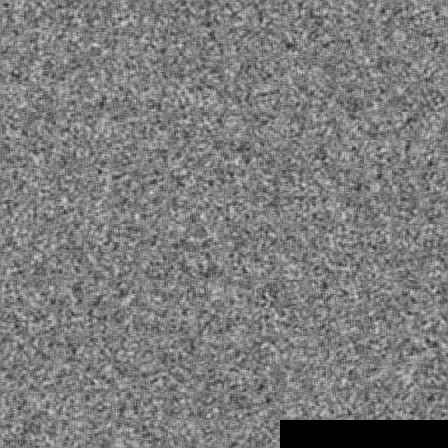

In [23]:
# начальное состояние
IPython.display.Image('result/00_0.png')

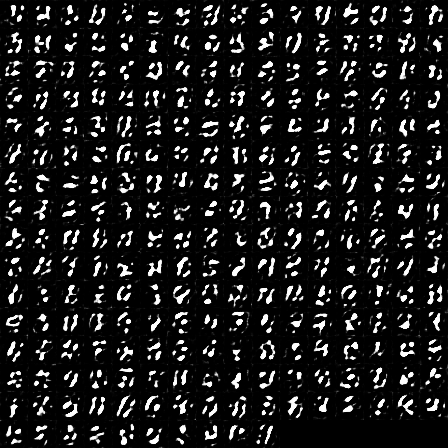

In [24]:
# после 1 эпохи обучения
IPython.display.Image('result/02_0.png')

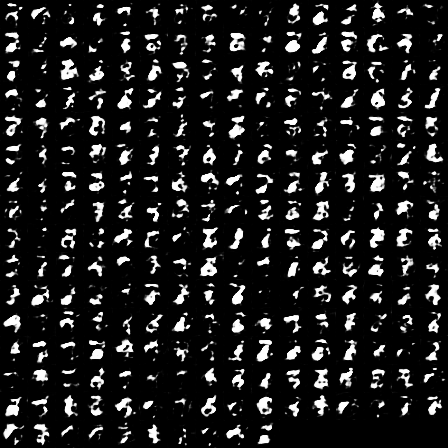

In [25]:
# после 9 эпохи обучения
IPython.display.Image('result/09_0.png')

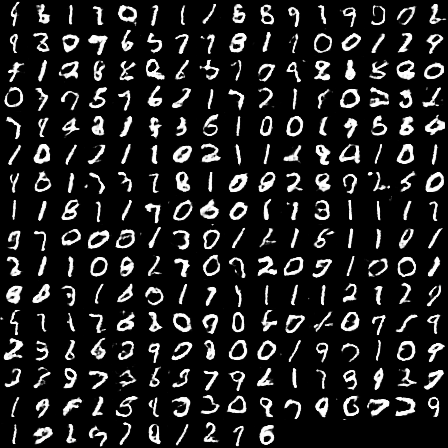

In [26]:
# конечный результат (50 эпох обучения)
IPython.display.Image('result/49_200.png')